In [1]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [4]:
def plot_magn(magn):
    scaled = magn ** 0.1
    plot(scaled / torch.max(scaled))
    
def plot_phase(phase):
    plot((phase + math.pi) / (2 * math.pi))

fashion


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


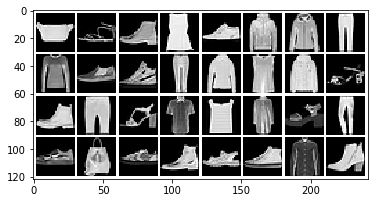

torch.Size([32, 1, 28, 28])


In [5]:
### LOAD DATA ###

dataset = 'fashion'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft ** 2, -1))
sample_phases = torch.atan2(sample_ft[..., 1], sample_ft[..., 0])

plot_grid(sample)
print(sample_magnitudes.shape)

Magnitude:


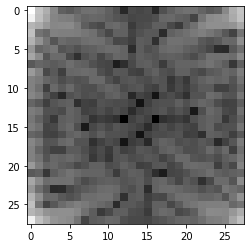

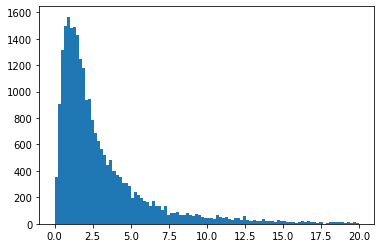

Phase:


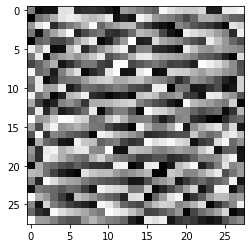

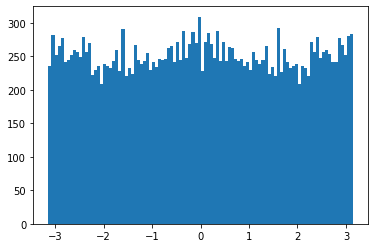

In [6]:
# Value distributions of magnitude and phase for the first sample

print("Magnitude:")
plot_magn(sample_magnitudes[0, 0])
plt.hist(sample_magnitudes.reshape(-1), bins=100, range=(0, 20))
plt.show()
print("Phase:")
plot_phase(sample_phases[0, 0])
plt.hist(sample_phases.reshape(-1), bins=100)
plt.show()

In [7]:
# Check for shapes of rfft transformation in Fourier and signal domain

sample_ft1 = torch.rfft(sample, 2, onesided=True)
print(sample_ft1.shape)
sample1 = torch.irfft(sample_ft1, 2, onesided=True, signal_sizes=(28, 28))
print(sample1[0].shape)

torch.Size([32, 1, 28, 15, 2])
torch.Size([1, 28, 28])


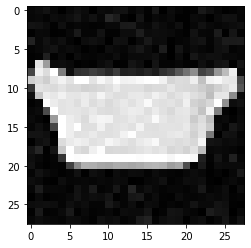

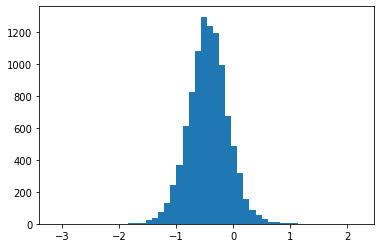

In [8]:
# Show how a small change in the signal space can disturb a specific phase
noise_level = 0.05
########
plot(sample[0] + noise_level * torch.abs(torch.randn(sample[0].shape)))

ph0 = []
for i in range(10000):
    ft = torch.rfft(sample[0] + noise_level * torch.randn(sample[0].shape), 2, onesided=True)
    ph0.append(torch.atan2(ft[..., 1], ft[..., 0])[0, 10, 10])
    
plt.hist(ph0, bins=50)
plt.show()

Gaussian in the signal domain cause Gaussian noise for the phases. But circular!

---

In [9]:
# Fully connected image network
class FCNet(nn.Module):

    __constants__ = ['mean', 'std']

    def __init__(self, imsize=(1, 28, 28), outsize=None, h=2048, mean=None, std=None):
        super(FCNet, self).__init__()
        print("Version 0.4")
        self.imsize = imsize
        if outsize is None:
            self.outsize = imsize
        else:
            self.outsize = outsize
        
        if mean is None:
            self.register_buffer('mean', torch.zeros(imsize))
        else:
            self.register_buffer('mean', torch.Tensor(mean))

        if std is None:
            self.register_buffer('std', torch.ones(imsize))
        else:
            self.register_buffer('std', torch.Tensor(std))
        
        self.layers = nn.Sequential(
            nn.Linear(imsize[0] * imsize[1] * imsize[2], h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h, self.outsize[0] * self.outsize[1] * self.outsize[2] * self.outsize[3]),
        )
        
    def forward(self, x):
    
        N = x.shape[0]

        out = self.layers(x.view(N, -1))
        return out.view(N, *self.outsize)

In [10]:
def calc_fourier(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    phs = torch.atan2(ft[..., 1], ft[..., 0])
    return mags, phs

In [11]:
# Define loss

def gen_loss(magn, pred_vec, phase):
    vec = torch.stack([torch.cos(phase), torch.sin(phase)], dim=-1)
    return  torch.mean((magn ** 2) * torch.sum((vec - pred_vec) ** 2, -1))

#def gen_loss(magn, pred_vec, phase):
#    vec = torch.stack([torch.cos(phase), torch.sin(phase)], dim=-1)
#    return  torch.mean(torch.sum((vec - pred_vec) ** 2, -1))

In [12]:
### Create new models ###

gen = FCNet(imsize=(1, 28, 28), outsize=(1, 28, 28, 2), h=2048)

Version 0.4


In [13]:
# Set training parameters

history = []
opt = optim.Adam(gen.parameters(), lr=1e-3)

In [14]:
# Initial loss

gen = gen.to(device)
sample = sample.to(device)
sample_magn, sample_phs = calc_fourier(sample)

pred_vec = gen(sample_magn)

loss = gen_loss(sample_magn, pred_vec, sample_phs)

print("Generator loss:", loss.item())

Generator loss: 179.2879638671875


In [15]:
def train_model(model, optimizer, device, loader_train, epochs=1):

    # move the model parameters to CPU/GPU
    model = model.to(device=device)
    
    history = []
    
    for e in range(epochs):

        for t, x in enumerate(loader_train):
            # put model to training mode
            model.train()
            
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)

            magn, phs = calc_fourier(x)

            # compute loss as pixel wise distance to original input
            pred_vec = model(magn)
            
            loss = gen_loss(magn, pred_vec, phs)
            #loss = torch.mean((x - out_real)**2) + torch.mean((phases - out_phases)**2)
            history.append(loss.item())

            # perform backprop and learning step
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e+1, t, history[-1]))
                
        plt.plot(history)
        plt.show()
                
    return history

epoch:  1 	 step:0 	 loss: 199.8
epoch:  1 	 step:100 	 loss: 26.22
epoch:  1 	 step:200 	 loss: 24.2
epoch:  1 	 step:300 	 loss: 26.37
epoch:  1 	 step:400 	 loss: 21.23
epoch:  1 	 step:500 	 loss: 19.8
epoch:  1 	 step:600 	 loss: 19.16
epoch:  1 	 step:700 	 loss: 17.83
epoch:  1 	 step:800 	 loss: 25.5
epoch:  1 	 step:900 	 loss: 17.29
epoch:  1 	 step:1000 	 loss: 24.44
epoch:  1 	 step:1100 	 loss: 19.36
epoch:  1 	 step:1200 	 loss: 16.35
epoch:  1 	 step:1300 	 loss: 20.34
epoch:  1 	 step:1400 	 loss: 22.7
epoch:  1 	 step:1500 	 loss: 17.17
epoch:  1 	 step:1600 	 loss: 18.67
epoch:  1 	 step:1700 	 loss: 14.56
epoch:  1 	 step:1800 	 loss: 18.54


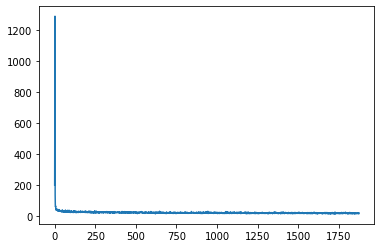

epoch:  2 	 step:0 	 loss: 15.73
epoch:  2 	 step:100 	 loss: 19.59
epoch:  2 	 step:200 	 loss: 18.05
epoch:  2 	 step:300 	 loss: 15.98
epoch:  2 	 step:400 	 loss: 17.0
epoch:  2 	 step:500 	 loss: 15.03
epoch:  2 	 step:600 	 loss: 16.84
epoch:  2 	 step:700 	 loss: 17.19
epoch:  2 	 step:800 	 loss: 17.05
epoch:  2 	 step:900 	 loss: 17.76
epoch:  2 	 step:1000 	 loss: 17.7
epoch:  2 	 step:1100 	 loss: 12.68
epoch:  2 	 step:1200 	 loss: 20.55
epoch:  2 	 step:1300 	 loss: 15.87
epoch:  2 	 step:1400 	 loss: 17.43
epoch:  2 	 step:1500 	 loss: 13.04
epoch:  2 	 step:1600 	 loss: 16.99
epoch:  2 	 step:1700 	 loss: 17.61
epoch:  2 	 step:1800 	 loss: 18.66


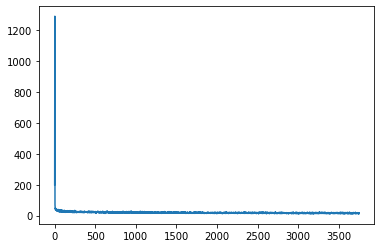

epoch:  3 	 step:0 	 loss: 15.04
epoch:  3 	 step:100 	 loss: 14.52
epoch:  3 	 step:200 	 loss: 13.49
epoch:  3 	 step:300 	 loss: 18.04
epoch:  3 	 step:400 	 loss: 18.23
epoch:  3 	 step:500 	 loss: 17.3
epoch:  3 	 step:600 	 loss: 15.62
epoch:  3 	 step:700 	 loss: 14.78
epoch:  3 	 step:800 	 loss: 16.72
epoch:  3 	 step:900 	 loss: 19.47
epoch:  3 	 step:1000 	 loss: 13.7
epoch:  3 	 step:1100 	 loss: 14.31
epoch:  3 	 step:1200 	 loss: 16.12
epoch:  3 	 step:1300 	 loss: 14.21
epoch:  3 	 step:1400 	 loss: 14.95
epoch:  3 	 step:1500 	 loss: 15.51
epoch:  3 	 step:1600 	 loss: 18.28
epoch:  3 	 step:1700 	 loss: 15.39
epoch:  3 	 step:1800 	 loss: 20.7


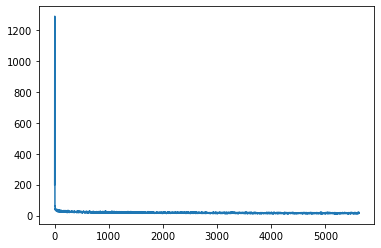

epoch:  4 	 step:0 	 loss: 14.62
epoch:  4 	 step:100 	 loss: 14.81
epoch:  4 	 step:200 	 loss: 15.3
epoch:  4 	 step:300 	 loss: 16.04
epoch:  4 	 step:400 	 loss: 14.14
epoch:  4 	 step:500 	 loss: 14.1
epoch:  4 	 step:600 	 loss: 14.13
epoch:  4 	 step:700 	 loss: 14.65
epoch:  4 	 step:800 	 loss: 11.0
epoch:  4 	 step:900 	 loss: 13.42
epoch:  4 	 step:1000 	 loss: 11.5
epoch:  4 	 step:1100 	 loss: 14.13
epoch:  4 	 step:1200 	 loss: 15.68
epoch:  4 	 step:1300 	 loss: 20.12
epoch:  4 	 step:1400 	 loss: 13.67
epoch:  4 	 step:1500 	 loss: 11.35
epoch:  4 	 step:1600 	 loss: 16.44
epoch:  4 	 step:1700 	 loss: 11.89
epoch:  4 	 step:1800 	 loss: 13.3


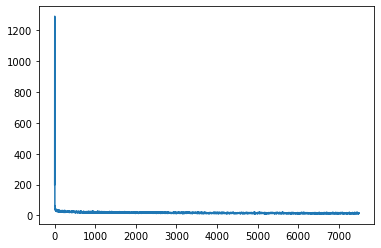

epoch:  5 	 step:0 	 loss: 13.69
epoch:  5 	 step:100 	 loss: 15.85
epoch:  5 	 step:200 	 loss: 13.3
epoch:  5 	 step:300 	 loss: 13.66
epoch:  5 	 step:400 	 loss: 12.29
epoch:  5 	 step:500 	 loss: 14.81
epoch:  5 	 step:600 	 loss: 13.97
epoch:  5 	 step:700 	 loss: 10.54
epoch:  5 	 step:800 	 loss: 16.58
epoch:  5 	 step:900 	 loss: 11.35
epoch:  5 	 step:1000 	 loss: 15.95
epoch:  5 	 step:1100 	 loss: 14.97
epoch:  5 	 step:1200 	 loss: 15.77
epoch:  5 	 step:1300 	 loss: 13.69
epoch:  5 	 step:1400 	 loss: 10.79
epoch:  5 	 step:1500 	 loss: 13.91
epoch:  5 	 step:1600 	 loss: 11.71
epoch:  5 	 step:1700 	 loss: 12.79
epoch:  5 	 step:1800 	 loss: 13.05


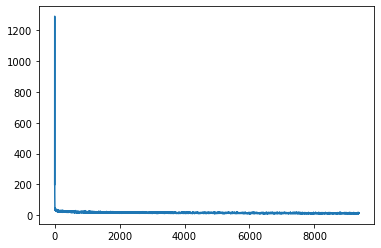

epoch:  6 	 step:0 	 loss: 11.46
epoch:  6 	 step:100 	 loss: 12.6
epoch:  6 	 step:200 	 loss: 12.64
epoch:  6 	 step:300 	 loss: 12.72
epoch:  6 	 step:400 	 loss: 13.69
epoch:  6 	 step:500 	 loss: 10.84
epoch:  6 	 step:600 	 loss: 12.96
epoch:  6 	 step:700 	 loss: 13.81
epoch:  6 	 step:800 	 loss: 12.88
epoch:  6 	 step:900 	 loss: 12.05
epoch:  6 	 step:1000 	 loss: 12.3
epoch:  6 	 step:1100 	 loss: 14.17
epoch:  6 	 step:1200 	 loss: 13.04
epoch:  6 	 step:1300 	 loss: 10.33
epoch:  6 	 step:1400 	 loss: 16.62
epoch:  6 	 step:1500 	 loss: 15.01
epoch:  6 	 step:1600 	 loss: 10.95
epoch:  6 	 step:1700 	 loss: 15.17
epoch:  6 	 step:1800 	 loss: 13.29


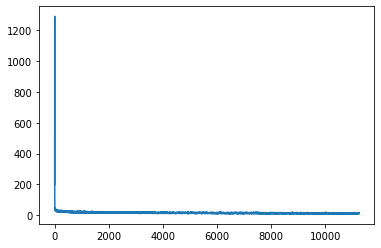

epoch:  7 	 step:0 	 loss: 11.73
epoch:  7 	 step:100 	 loss: 11.1
epoch:  7 	 step:200 	 loss: 11.76
epoch:  7 	 step:300 	 loss: 11.45
epoch:  7 	 step:400 	 loss: 13.47
epoch:  7 	 step:500 	 loss: 13.3
epoch:  7 	 step:600 	 loss: 11.38
epoch:  7 	 step:700 	 loss: 13.89
epoch:  7 	 step:800 	 loss: 11.57
epoch:  7 	 step:900 	 loss: 15.74
epoch:  7 	 step:1000 	 loss: 11.83
epoch:  7 	 step:1100 	 loss: 12.01
epoch:  7 	 step:1200 	 loss: 11.64
epoch:  7 	 step:1300 	 loss: 9.981
epoch:  7 	 step:1400 	 loss: 14.66
epoch:  7 	 step:1500 	 loss: 13.87
epoch:  7 	 step:1600 	 loss: 11.5
epoch:  7 	 step:1700 	 loss: 11.49
epoch:  7 	 step:1800 	 loss: 11.96


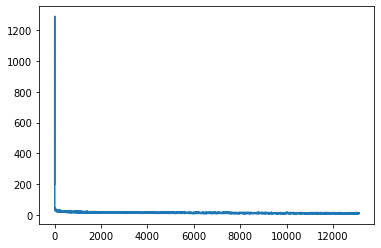

epoch:  8 	 step:0 	 loss: 16.3
epoch:  8 	 step:100 	 loss: 13.24
epoch:  8 	 step:200 	 loss: 12.38
epoch:  8 	 step:300 	 loss: 11.08
epoch:  8 	 step:400 	 loss: 14.13
epoch:  8 	 step:500 	 loss: 12.56
epoch:  8 	 step:600 	 loss: 11.11
epoch:  8 	 step:700 	 loss: 13.67
epoch:  8 	 step:800 	 loss: 12.96
epoch:  8 	 step:900 	 loss: 13.08
epoch:  8 	 step:1000 	 loss: 14.25
epoch:  8 	 step:1100 	 loss: 10.94
epoch:  8 	 step:1200 	 loss: 8.751
epoch:  8 	 step:1300 	 loss: 10.04
epoch:  8 	 step:1400 	 loss: 11.64
epoch:  8 	 step:1500 	 loss: 11.86
epoch:  8 	 step:1600 	 loss: 16.33
epoch:  8 	 step:1700 	 loss: 10.94
epoch:  8 	 step:1800 	 loss: 10.8


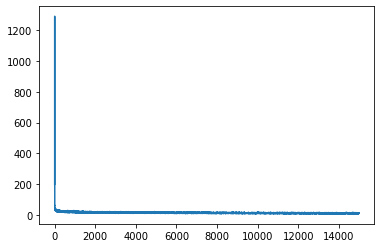

epoch:  9 	 step:0 	 loss: 13.68
epoch:  9 	 step:100 	 loss: 11.16
epoch:  9 	 step:200 	 loss: 10.23
epoch:  9 	 step:300 	 loss: 11.25
epoch:  9 	 step:400 	 loss: 14.59
epoch:  9 	 step:500 	 loss: 10.02
epoch:  9 	 step:600 	 loss: 12.53
epoch:  9 	 step:700 	 loss: 12.71
epoch:  9 	 step:800 	 loss: 13.06
epoch:  9 	 step:900 	 loss: 12.34
epoch:  9 	 step:1000 	 loss: 8.205
epoch:  9 	 step:1100 	 loss: 14.44
epoch:  9 	 step:1200 	 loss: 12.86
epoch:  9 	 step:1300 	 loss: 13.35
epoch:  9 	 step:1400 	 loss: 11.33
epoch:  9 	 step:1500 	 loss: 14.09
epoch:  9 	 step:1600 	 loss: 14.6
epoch:  9 	 step:1700 	 loss: 11.0
epoch:  9 	 step:1800 	 loss: 12.77


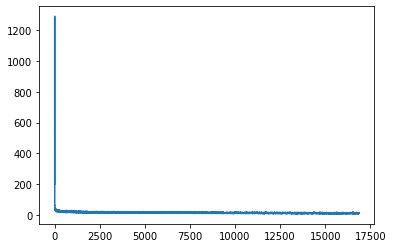

epoch: 10 	 step:0 	 loss: 10.93
epoch: 10 	 step:100 	 loss: 9.944
epoch: 10 	 step:200 	 loss: 8.841
epoch: 10 	 step:300 	 loss: 14.37
epoch: 10 	 step:400 	 loss: 10.23
epoch: 10 	 step:500 	 loss: 10.64
epoch: 10 	 step:600 	 loss: 9.417
epoch: 10 	 step:700 	 loss: 13.15
epoch: 10 	 step:800 	 loss: 9.14
epoch: 10 	 step:900 	 loss: 11.62
epoch: 10 	 step:1000 	 loss: 9.465
epoch: 10 	 step:1100 	 loss: 10.16
epoch: 10 	 step:1200 	 loss: 11.06
epoch: 10 	 step:1300 	 loss: 14.52
epoch: 10 	 step:1400 	 loss: 12.21
epoch: 10 	 step:1500 	 loss: 10.97
epoch: 10 	 step:1600 	 loss: 8.971
epoch: 10 	 step:1700 	 loss: 11.2
epoch: 10 	 step:1800 	 loss: 15.08


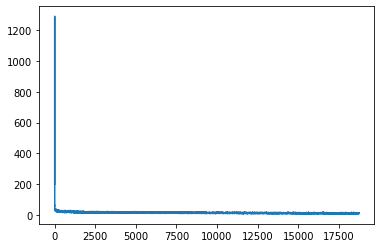

epoch: 11 	 step:0 	 loss: 12.12
epoch: 11 	 step:100 	 loss: 11.3
epoch: 11 	 step:200 	 loss: 11.46
epoch: 11 	 step:300 	 loss: 11.71
epoch: 11 	 step:400 	 loss: 10.33
epoch: 11 	 step:500 	 loss: 11.16
epoch: 11 	 step:600 	 loss: 12.22
epoch: 11 	 step:700 	 loss: 10.06
epoch: 11 	 step:800 	 loss: 9.75
epoch: 11 	 step:900 	 loss: 13.47
epoch: 11 	 step:1000 	 loss: 13.2
epoch: 11 	 step:1100 	 loss: 10.48
epoch: 11 	 step:1200 	 loss: 8.87
epoch: 11 	 step:1300 	 loss: 10.05
epoch: 11 	 step:1400 	 loss: 13.51
epoch: 11 	 step:1500 	 loss: 12.66
epoch: 11 	 step:1600 	 loss: 13.22
epoch: 11 	 step:1700 	 loss: 9.722
epoch: 11 	 step:1800 	 loss: 10.96


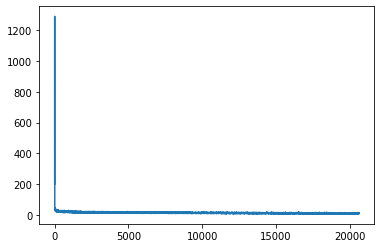

epoch: 12 	 step:0 	 loss: 12.23
epoch: 12 	 step:100 	 loss: 10.33
epoch: 12 	 step:200 	 loss: 11.82
epoch: 12 	 step:300 	 loss: 10.28
epoch: 12 	 step:400 	 loss: 9.515
epoch: 12 	 step:500 	 loss: 11.33
epoch: 12 	 step:600 	 loss: 9.874
epoch: 12 	 step:700 	 loss: 11.95
epoch: 12 	 step:800 	 loss: 13.89
epoch: 12 	 step:900 	 loss: 9.388
epoch: 12 	 step:1000 	 loss: 9.256
epoch: 12 	 step:1100 	 loss: 11.28
epoch: 12 	 step:1200 	 loss: 9.204
epoch: 12 	 step:1300 	 loss: 10.1
epoch: 12 	 step:1400 	 loss: 9.043
epoch: 12 	 step:1500 	 loss: 11.55
epoch: 12 	 step:1600 	 loss: 10.5
epoch: 12 	 step:1700 	 loss: 10.04
epoch: 12 	 step:1800 	 loss: 10.89


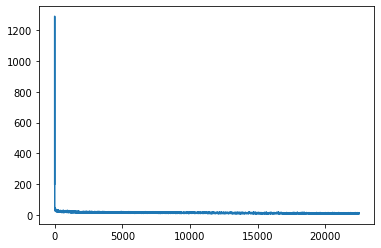

epoch: 13 	 step:0 	 loss: 9.449
epoch: 13 	 step:100 	 loss: 11.11
epoch: 13 	 step:200 	 loss: 10.16
epoch: 13 	 step:300 	 loss: 8.203
epoch: 13 	 step:400 	 loss: 11.45
epoch: 13 	 step:500 	 loss: 10.02
epoch: 13 	 step:600 	 loss: 12.42
epoch: 13 	 step:700 	 loss: 12.37
epoch: 13 	 step:800 	 loss: 11.65
epoch: 13 	 step:900 	 loss: 11.06
epoch: 13 	 step:1000 	 loss: 9.115
epoch: 13 	 step:1100 	 loss: 10.11
epoch: 13 	 step:1200 	 loss: 11.56
epoch: 13 	 step:1300 	 loss: 9.265
epoch: 13 	 step:1400 	 loss: 13.8
epoch: 13 	 step:1500 	 loss: 11.06
epoch: 13 	 step:1600 	 loss: 9.87
epoch: 13 	 step:1700 	 loss: 10.54
epoch: 13 	 step:1800 	 loss: 10.85


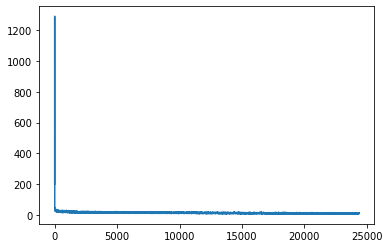

epoch: 14 	 step:0 	 loss: 12.17
epoch: 14 	 step:100 	 loss: 10.49
epoch: 14 	 step:200 	 loss: 7.87
epoch: 14 	 step:300 	 loss: 10.36
epoch: 14 	 step:400 	 loss: 10.58
epoch: 14 	 step:500 	 loss: 10.93
epoch: 14 	 step:600 	 loss: 10.33
epoch: 14 	 step:700 	 loss: 10.13
epoch: 14 	 step:800 	 loss: 8.451
epoch: 14 	 step:900 	 loss: 10.15
epoch: 14 	 step:1000 	 loss: 8.598
epoch: 14 	 step:1100 	 loss: 11.92
epoch: 14 	 step:1200 	 loss: 9.42
epoch: 14 	 step:1300 	 loss: 10.76
epoch: 14 	 step:1400 	 loss: 11.21
epoch: 14 	 step:1500 	 loss: 11.39
epoch: 14 	 step:1600 	 loss: 9.202
epoch: 14 	 step:1700 	 loss: 12.56
epoch: 14 	 step:1800 	 loss: 11.12


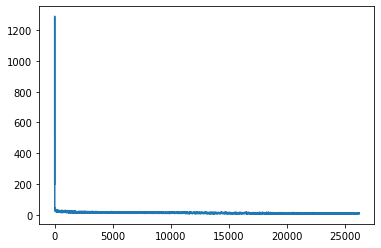

epoch: 15 	 step:0 	 loss: 10.8
epoch: 15 	 step:100 	 loss: 12.33
epoch: 15 	 step:200 	 loss: 11.07
epoch: 15 	 step:300 	 loss: 8.472
epoch: 15 	 step:400 	 loss: 10.46
epoch: 15 	 step:500 	 loss: 10.03
epoch: 15 	 step:600 	 loss: 10.27
epoch: 15 	 step:700 	 loss: 9.859
epoch: 15 	 step:800 	 loss: 9.365
epoch: 15 	 step:900 	 loss: 9.912
epoch: 15 	 step:1000 	 loss: 9.573
epoch: 15 	 step:1100 	 loss: 10.81
epoch: 15 	 step:1200 	 loss: 9.009
epoch: 15 	 step:1300 	 loss: 11.69
epoch: 15 	 step:1400 	 loss: 11.12
epoch: 15 	 step:1500 	 loss: 9.354
epoch: 15 	 step:1600 	 loss: 9.768
epoch: 15 	 step:1700 	 loss: 8.63
epoch: 15 	 step:1800 	 loss: 10.71


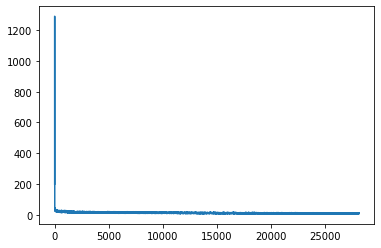

epoch: 16 	 step:0 	 loss: 10.82
epoch: 16 	 step:100 	 loss: 11.03
epoch: 16 	 step:200 	 loss: 10.09
epoch: 16 	 step:300 	 loss: 9.629
epoch: 16 	 step:400 	 loss: 9.747
epoch: 16 	 step:500 	 loss: 8.78
epoch: 16 	 step:600 	 loss: 9.233
epoch: 16 	 step:700 	 loss: 11.24
epoch: 16 	 step:800 	 loss: 9.582
epoch: 16 	 step:900 	 loss: 11.43
epoch: 16 	 step:1000 	 loss: 10.39
epoch: 16 	 step:1100 	 loss: 10.98
epoch: 16 	 step:1200 	 loss: 11.28
epoch: 16 	 step:1300 	 loss: 9.572
epoch: 16 	 step:1400 	 loss: 9.714
epoch: 16 	 step:1500 	 loss: 8.507
epoch: 16 	 step:1600 	 loss: 9.299
epoch: 16 	 step:1700 	 loss: 8.655
epoch: 16 	 step:1800 	 loss: 8.626


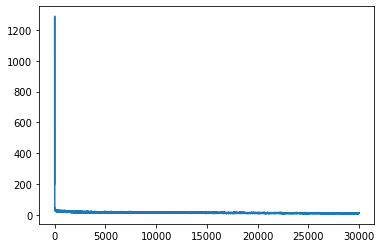

epoch: 17 	 step:0 	 loss: 8.385
epoch: 17 	 step:100 	 loss: 9.132
epoch: 17 	 step:200 	 loss: 10.69
epoch: 17 	 step:300 	 loss: 8.001
epoch: 17 	 step:400 	 loss: 10.09
epoch: 17 	 step:500 	 loss: 7.714
epoch: 17 	 step:600 	 loss: 9.142
epoch: 17 	 step:700 	 loss: 8.657
epoch: 17 	 step:800 	 loss: 9.803
epoch: 17 	 step:900 	 loss: 10.36
epoch: 17 	 step:1000 	 loss: 8.044
epoch: 17 	 step:1100 	 loss: 10.54
epoch: 17 	 step:1200 	 loss: 9.526
epoch: 17 	 step:1300 	 loss: 8.912
epoch: 17 	 step:1400 	 loss: 8.867
epoch: 17 	 step:1500 	 loss: 11.76
epoch: 17 	 step:1600 	 loss: 8.397
epoch: 17 	 step:1700 	 loss: 11.38
epoch: 17 	 step:1800 	 loss: 9.32


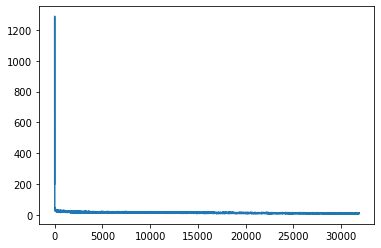

epoch: 18 	 step:0 	 loss: 11.3
epoch: 18 	 step:100 	 loss: 7.508
epoch: 18 	 step:200 	 loss: 9.288
epoch: 18 	 step:300 	 loss: 8.962
epoch: 18 	 step:400 	 loss: 9.974
epoch: 18 	 step:500 	 loss: 9.942
epoch: 18 	 step:600 	 loss: 8.671
epoch: 18 	 step:700 	 loss: 8.612
epoch: 18 	 step:800 	 loss: 9.852
epoch: 18 	 step:900 	 loss: 9.391
epoch: 18 	 step:1000 	 loss: 9.488
epoch: 18 	 step:1100 	 loss: 9.398
epoch: 18 	 step:1200 	 loss: 10.59
epoch: 18 	 step:1300 	 loss: 11.02
epoch: 18 	 step:1400 	 loss: 9.245
epoch: 18 	 step:1500 	 loss: 9.668
epoch: 18 	 step:1600 	 loss: 7.686
epoch: 18 	 step:1700 	 loss: 9.058
epoch: 18 	 step:1800 	 loss: 9.302


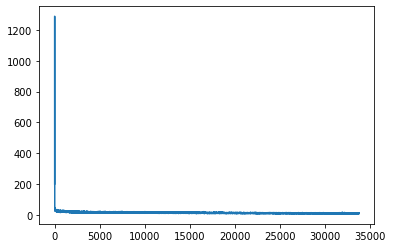

epoch: 19 	 step:0 	 loss: 8.562
epoch: 19 	 step:100 	 loss: 10.44
epoch: 19 	 step:200 	 loss: 9.487
epoch: 19 	 step:300 	 loss: 10.91
epoch: 19 	 step:400 	 loss: 9.355
epoch: 19 	 step:500 	 loss: 7.268
epoch: 19 	 step:600 	 loss: 8.628
epoch: 19 	 step:700 	 loss: 9.841
epoch: 19 	 step:800 	 loss: 7.186
epoch: 19 	 step:900 	 loss: 8.763
epoch: 19 	 step:1000 	 loss: 8.035
epoch: 19 	 step:1100 	 loss: 9.514
epoch: 19 	 step:1200 	 loss: 9.604
epoch: 19 	 step:1300 	 loss: 9.018
epoch: 19 	 step:1400 	 loss: 11.64
epoch: 19 	 step:1500 	 loss: 9.204
epoch: 19 	 step:1600 	 loss: 9.437
epoch: 19 	 step:1700 	 loss: 9.407
epoch: 19 	 step:1800 	 loss: 8.302


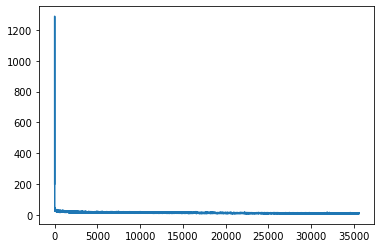

epoch: 20 	 step:0 	 loss: 7.416
epoch: 20 	 step:100 	 loss: 8.087
epoch: 20 	 step:200 	 loss: 7.812
epoch: 20 	 step:300 	 loss: 5.886
epoch: 20 	 step:400 	 loss: 8.167
epoch: 20 	 step:500 	 loss: 10.96
epoch: 20 	 step:600 	 loss: 9.062
epoch: 20 	 step:700 	 loss: 9.093
epoch: 20 	 step:800 	 loss: 8.456
epoch: 20 	 step:900 	 loss: 8.526
epoch: 20 	 step:1000 	 loss: 8.599
epoch: 20 	 step:1100 	 loss: 8.917
epoch: 20 	 step:1200 	 loss: 9.116
epoch: 20 	 step:1300 	 loss: 9.581
epoch: 20 	 step:1400 	 loss: 9.479
epoch: 20 	 step:1500 	 loss: 10.89
epoch: 20 	 step:1600 	 loss: 9.4
epoch: 20 	 step:1700 	 loss: 9.161
epoch: 20 	 step:1800 	 loss: 9.338


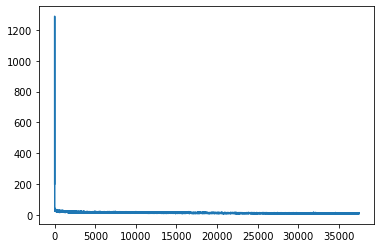

epoch: 21 	 step:0 	 loss: 9.248
epoch: 21 	 step:100 	 loss: 9.088
epoch: 21 	 step:200 	 loss: 8.469
epoch: 21 	 step:300 	 loss: 7.998
epoch: 21 	 step:400 	 loss: 8.229
epoch: 21 	 step:500 	 loss: 8.032
epoch: 21 	 step:600 	 loss: 8.091
epoch: 21 	 step:700 	 loss: 9.743
epoch: 21 	 step:800 	 loss: 10.71
epoch: 21 	 step:900 	 loss: 10.32
epoch: 21 	 step:1000 	 loss: 9.354
epoch: 21 	 step:1100 	 loss: 8.346
epoch: 21 	 step:1200 	 loss: 8.83
epoch: 21 	 step:1300 	 loss: 8.799
epoch: 21 	 step:1400 	 loss: 9.404
epoch: 21 	 step:1500 	 loss: 9.135
epoch: 21 	 step:1600 	 loss: 8.058
epoch: 21 	 step:1700 	 loss: 10.74
epoch: 21 	 step:1800 	 loss: 10.79


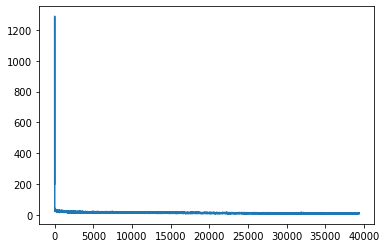

epoch: 22 	 step:0 	 loss: 7.822
epoch: 22 	 step:100 	 loss: 8.508
epoch: 22 	 step:200 	 loss: 7.69
epoch: 22 	 step:300 	 loss: 7.71
epoch: 22 	 step:400 	 loss: 8.025
epoch: 22 	 step:500 	 loss: 8.37
epoch: 22 	 step:600 	 loss: 7.847
epoch: 22 	 step:700 	 loss: 8.514
epoch: 22 	 step:800 	 loss: 8.056
epoch: 22 	 step:900 	 loss: 7.923
epoch: 22 	 step:1000 	 loss: 7.915
epoch: 22 	 step:1100 	 loss: 8.833
epoch: 22 	 step:1200 	 loss: 10.55
epoch: 22 	 step:1300 	 loss: 9.54
epoch: 22 	 step:1400 	 loss: 8.753
epoch: 22 	 step:1500 	 loss: 6.391
epoch: 22 	 step:1600 	 loss: 7.978
epoch: 22 	 step:1700 	 loss: 8.663
epoch: 22 	 step:1800 	 loss: 8.806


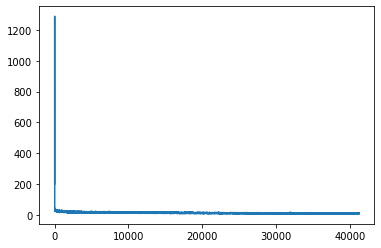

epoch: 23 	 step:0 	 loss: 7.853
epoch: 23 	 step:100 	 loss: 8.855
epoch: 23 	 step:200 	 loss: 8.079
epoch: 23 	 step:300 	 loss: 7.111
epoch: 23 	 step:400 	 loss: 7.751
epoch: 23 	 step:500 	 loss: 9.177
epoch: 23 	 step:600 	 loss: 8.512
epoch: 23 	 step:700 	 loss: 7.852
epoch: 23 	 step:800 	 loss: 8.969
epoch: 23 	 step:900 	 loss: 11.44
epoch: 23 	 step:1000 	 loss: 10.89
epoch: 23 	 step:1100 	 loss: 8.545
epoch: 23 	 step:1200 	 loss: 8.238
epoch: 23 	 step:1300 	 loss: 9.188
epoch: 23 	 step:1400 	 loss: 9.218
epoch: 23 	 step:1500 	 loss: 9.234
epoch: 23 	 step:1600 	 loss: 8.005
epoch: 23 	 step:1700 	 loss: 8.876
epoch: 23 	 step:1800 	 loss: 8.715


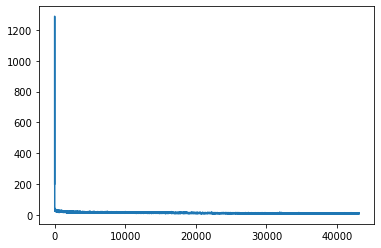

epoch: 24 	 step:0 	 loss: 6.5
epoch: 24 	 step:100 	 loss: 7.085
epoch: 24 	 step:200 	 loss: 8.985
epoch: 24 	 step:300 	 loss: 6.788
epoch: 24 	 step:400 	 loss: 7.009
epoch: 24 	 step:500 	 loss: 8.849
epoch: 24 	 step:600 	 loss: 7.909
epoch: 24 	 step:700 	 loss: 8.104
epoch: 24 	 step:800 	 loss: 8.472
epoch: 24 	 step:900 	 loss: 6.91
epoch: 24 	 step:1000 	 loss: 7.955
epoch: 24 	 step:1100 	 loss: 7.112
epoch: 24 	 step:1200 	 loss: 7.046
epoch: 24 	 step:1300 	 loss: 9.924
epoch: 24 	 step:1400 	 loss: 9.798
epoch: 24 	 step:1500 	 loss: 8.247
epoch: 24 	 step:1600 	 loss: 7.861
epoch: 24 	 step:1700 	 loss: 10.2
epoch: 24 	 step:1800 	 loss: 8.812


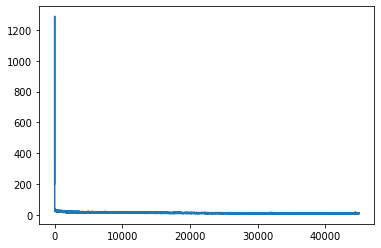

epoch: 25 	 step:0 	 loss: 7.445
epoch: 25 	 step:100 	 loss: 8.613
epoch: 25 	 step:200 	 loss: 7.831
epoch: 25 	 step:300 	 loss: 7.685
epoch: 25 	 step:400 	 loss: 7.893
epoch: 25 	 step:500 	 loss: 7.987
epoch: 25 	 step:600 	 loss: 7.579
epoch: 25 	 step:700 	 loss: 9.368
epoch: 25 	 step:800 	 loss: 6.677
epoch: 25 	 step:900 	 loss: 8.397
epoch: 25 	 step:1000 	 loss: 9.522
epoch: 25 	 step:1100 	 loss: 9.403
epoch: 25 	 step:1200 	 loss: 7.789
epoch: 25 	 step:1300 	 loss: 8.61
epoch: 25 	 step:1400 	 loss: 9.198
epoch: 25 	 step:1500 	 loss: 9.949
epoch: 25 	 step:1600 	 loss: 8.705
epoch: 25 	 step:1700 	 loss: 7.606
epoch: 25 	 step:1800 	 loss: 8.302


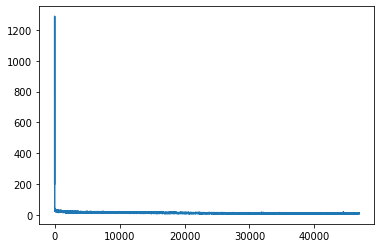

epoch: 26 	 step:0 	 loss: 8.463
epoch: 26 	 step:100 	 loss: 8.55
epoch: 26 	 step:200 	 loss: 8.196
epoch: 26 	 step:300 	 loss: 7.293
epoch: 26 	 step:400 	 loss: 6.703
epoch: 26 	 step:500 	 loss: 6.907
epoch: 26 	 step:600 	 loss: 8.399
epoch: 26 	 step:700 	 loss: 8.11
epoch: 26 	 step:800 	 loss: 7.526
epoch: 26 	 step:900 	 loss: 6.247
epoch: 26 	 step:1000 	 loss: 8.347
epoch: 26 	 step:1100 	 loss: 8.314
epoch: 26 	 step:1200 	 loss: 9.112
epoch: 26 	 step:1300 	 loss: 7.506
epoch: 26 	 step:1400 	 loss: 8.627
epoch: 26 	 step:1500 	 loss: 8.839
epoch: 26 	 step:1600 	 loss: 8.487
epoch: 26 	 step:1700 	 loss: 8.867
epoch: 26 	 step:1800 	 loss: 6.63


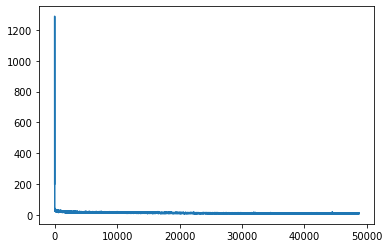

epoch: 27 	 step:0 	 loss: 8.818
epoch: 27 	 step:100 	 loss: 9.389
epoch: 27 	 step:200 	 loss: 8.005
epoch: 27 	 step:300 	 loss: 8.865
epoch: 27 	 step:400 	 loss: 7.105
epoch: 27 	 step:500 	 loss: 8.488
epoch: 27 	 step:600 	 loss: 8.301
epoch: 27 	 step:700 	 loss: 7.632
epoch: 27 	 step:800 	 loss: 7.748
epoch: 27 	 step:900 	 loss: 9.448
epoch: 27 	 step:1000 	 loss: 8.074
epoch: 27 	 step:1100 	 loss: 9.622
epoch: 27 	 step:1200 	 loss: 8.354
epoch: 27 	 step:1300 	 loss: 7.484
epoch: 27 	 step:1400 	 loss: 9.745
epoch: 27 	 step:1500 	 loss: 8.744
epoch: 27 	 step:1600 	 loss: 8.176
epoch: 27 	 step:1700 	 loss: 9.128
epoch: 27 	 step:1800 	 loss: 8.018


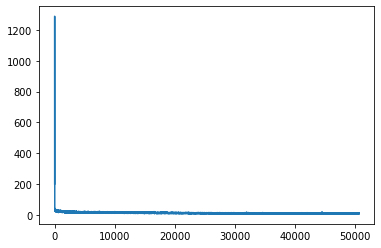

epoch: 28 	 step:0 	 loss: 8.985
epoch: 28 	 step:100 	 loss: 9.458
epoch: 28 	 step:200 	 loss: 7.686
epoch: 28 	 step:300 	 loss: 6.694
epoch: 28 	 step:400 	 loss: 8.584
epoch: 28 	 step:500 	 loss: 8.493
epoch: 28 	 step:600 	 loss: 6.735
epoch: 28 	 step:700 	 loss: 7.134
epoch: 28 	 step:800 	 loss: 7.883
epoch: 28 	 step:900 	 loss: 6.849
epoch: 28 	 step:1000 	 loss: 8.784
epoch: 28 	 step:1100 	 loss: 9.643
epoch: 28 	 step:1200 	 loss: 10.2
epoch: 28 	 step:1300 	 loss: 9.364
epoch: 28 	 step:1400 	 loss: 7.599
epoch: 28 	 step:1500 	 loss: 9.541
epoch: 28 	 step:1600 	 loss: 9.749
epoch: 28 	 step:1700 	 loss: 7.484
epoch: 28 	 step:1800 	 loss: 7.511


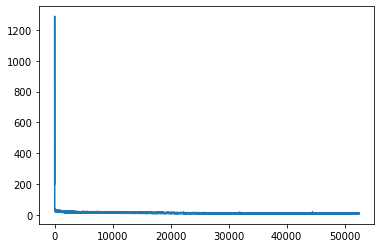

epoch: 29 	 step:0 	 loss: 7.048
epoch: 29 	 step:100 	 loss: 7.384
epoch: 29 	 step:200 	 loss: 7.879
epoch: 29 	 step:300 	 loss: 8.054
epoch: 29 	 step:400 	 loss: 8.296
epoch: 29 	 step:500 	 loss: 7.618
epoch: 29 	 step:600 	 loss: 7.52
epoch: 29 	 step:700 	 loss: 7.613
epoch: 29 	 step:800 	 loss: 8.611
epoch: 29 	 step:900 	 loss: 7.579
epoch: 29 	 step:1000 	 loss: 7.29
epoch: 29 	 step:1100 	 loss: 8.165
epoch: 29 	 step:1200 	 loss: 9.408
epoch: 29 	 step:1300 	 loss: 7.476
epoch: 29 	 step:1400 	 loss: 6.499
epoch: 29 	 step:1500 	 loss: 7.533
epoch: 29 	 step:1600 	 loss: 8.981
epoch: 29 	 step:1700 	 loss: 8.898
epoch: 29 	 step:1800 	 loss: 6.305


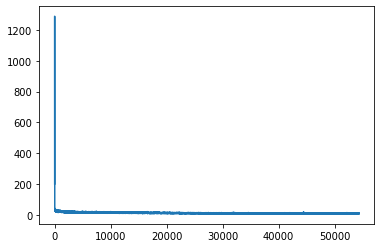

epoch: 30 	 step:0 	 loss: 6.252
epoch: 30 	 step:100 	 loss: 7.932
epoch: 30 	 step:200 	 loss: 8.226
epoch: 30 	 step:300 	 loss: 6.321
epoch: 30 	 step:400 	 loss: 6.819
epoch: 30 	 step:500 	 loss: 6.929
epoch: 30 	 step:600 	 loss: 6.442
epoch: 30 	 step:700 	 loss: 10.54
epoch: 30 	 step:800 	 loss: 7.088
epoch: 30 	 step:900 	 loss: 8.831
epoch: 30 	 step:1000 	 loss: 7.03
epoch: 30 	 step:1100 	 loss: 7.402
epoch: 30 	 step:1200 	 loss: 7.042
epoch: 30 	 step:1300 	 loss: 7.6
epoch: 30 	 step:1400 	 loss: 6.641
epoch: 30 	 step:1500 	 loss: 7.185
epoch: 30 	 step:1600 	 loss: 8.293
epoch: 30 	 step:1700 	 loss: 7.278
epoch: 30 	 step:1800 	 loss: 7.131


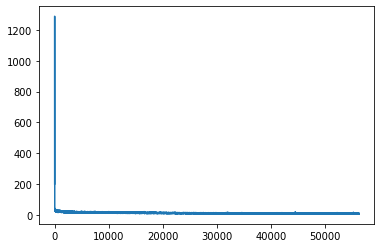

epoch: 31 	 step:0 	 loss: 6.325
epoch: 31 	 step:100 	 loss: 6.348
epoch: 31 	 step:200 	 loss: 7.967
epoch: 31 	 step:300 	 loss: 7.097
epoch: 31 	 step:400 	 loss: 7.986
epoch: 31 	 step:500 	 loss: 7.051
epoch: 31 	 step:600 	 loss: 7.587
epoch: 31 	 step:700 	 loss: 8.964
epoch: 31 	 step:800 	 loss: 5.327
epoch: 31 	 step:900 	 loss: 8.012
epoch: 31 	 step:1000 	 loss: 7.027
epoch: 31 	 step:1100 	 loss: 8.232
epoch: 31 	 step:1200 	 loss: 6.684
epoch: 31 	 step:1300 	 loss: 7.092
epoch: 31 	 step:1400 	 loss: 6.666
epoch: 31 	 step:1500 	 loss: 8.636
epoch: 31 	 step:1600 	 loss: 8.578
epoch: 31 	 step:1700 	 loss: 8.751
epoch: 31 	 step:1800 	 loss: 7.793


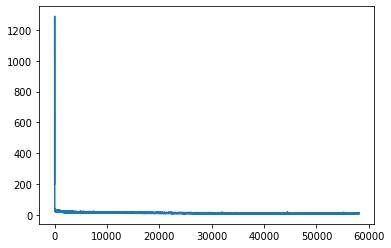

epoch: 32 	 step:0 	 loss: 7.611
epoch: 32 	 step:100 	 loss: 6.897
epoch: 32 	 step:200 	 loss: 7.528
epoch: 32 	 step:300 	 loss: 8.31
epoch: 32 	 step:400 	 loss: 6.435
epoch: 32 	 step:500 	 loss: 6.712
epoch: 32 	 step:600 	 loss: 7.452
epoch: 32 	 step:700 	 loss: 6.939
epoch: 32 	 step:800 	 loss: 8.047
epoch: 32 	 step:900 	 loss: 6.526
epoch: 32 	 step:1000 	 loss: 7.519
epoch: 32 	 step:1100 	 loss: 6.167
epoch: 32 	 step:1200 	 loss: 7.726
epoch: 32 	 step:1300 	 loss: 6.05
epoch: 32 	 step:1400 	 loss: 6.627
epoch: 32 	 step:1500 	 loss: 7.695
epoch: 32 	 step:1600 	 loss: 6.977
epoch: 32 	 step:1700 	 loss: 9.006
epoch: 32 	 step:1800 	 loss: 7.548


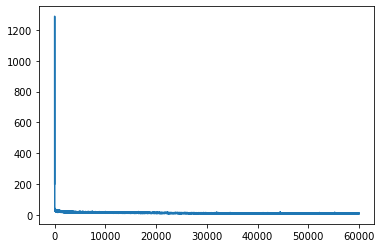

epoch: 33 	 step:0 	 loss: 8.343
epoch: 33 	 step:100 	 loss: 7.333
epoch: 33 	 step:200 	 loss: 7.751
epoch: 33 	 step:300 	 loss: 6.763
epoch: 33 	 step:400 	 loss: 6.559
epoch: 33 	 step:500 	 loss: 7.333
epoch: 33 	 step:600 	 loss: 6.111
epoch: 33 	 step:700 	 loss: 8.786
epoch: 33 	 step:800 	 loss: 7.711
epoch: 33 	 step:900 	 loss: 6.524
epoch: 33 	 step:1000 	 loss: 7.925
epoch: 33 	 step:1100 	 loss: 8.896
epoch: 33 	 step:1200 	 loss: 7.462
epoch: 33 	 step:1300 	 loss: 7.346
epoch: 33 	 step:1400 	 loss: 6.474
epoch: 33 	 step:1500 	 loss: 6.967
epoch: 33 	 step:1600 	 loss: 6.673
epoch: 33 	 step:1700 	 loss: 5.705
epoch: 33 	 step:1800 	 loss: 7.314


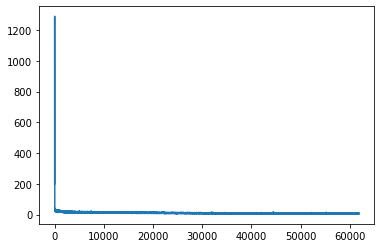

epoch: 34 	 step:0 	 loss: 8.396
epoch: 34 	 step:100 	 loss: 6.761
epoch: 34 	 step:200 	 loss: 8.197
epoch: 34 	 step:300 	 loss: 6.347
epoch: 34 	 step:400 	 loss: 6.775
epoch: 34 	 step:500 	 loss: 5.914
epoch: 34 	 step:600 	 loss: 6.252
epoch: 34 	 step:700 	 loss: 6.87
epoch: 34 	 step:800 	 loss: 7.391
epoch: 34 	 step:900 	 loss: 6.829
epoch: 34 	 step:1000 	 loss: 7.211
epoch: 34 	 step:1100 	 loss: 7.311
epoch: 34 	 step:1200 	 loss: 7.303
epoch: 34 	 step:1300 	 loss: 6.549
epoch: 34 	 step:1400 	 loss: 6.849
epoch: 34 	 step:1500 	 loss: 7.451
epoch: 34 	 step:1600 	 loss: 8.317
epoch: 34 	 step:1700 	 loss: 6.447
epoch: 34 	 step:1800 	 loss: 8.138


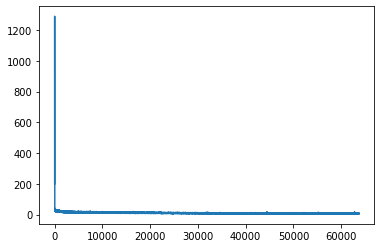

epoch: 35 	 step:0 	 loss: 7.494
epoch: 35 	 step:100 	 loss: 7.367
epoch: 35 	 step:200 	 loss: 6.37
epoch: 35 	 step:300 	 loss: 7.083
epoch: 35 	 step:400 	 loss: 6.947
epoch: 35 	 step:500 	 loss: 6.476
epoch: 35 	 step:600 	 loss: 7.366
epoch: 35 	 step:700 	 loss: 6.402
epoch: 35 	 step:800 	 loss: 7.358
epoch: 35 	 step:900 	 loss: 6.833
epoch: 35 	 step:1000 	 loss: 6.799
epoch: 35 	 step:1100 	 loss: 8.351
epoch: 35 	 step:1200 	 loss: 7.384
epoch: 35 	 step:1300 	 loss: 6.71
epoch: 35 	 step:1400 	 loss: 6.812
epoch: 35 	 step:1500 	 loss: 7.383
epoch: 35 	 step:1600 	 loss: 6.191
epoch: 35 	 step:1700 	 loss: 6.983
epoch: 35 	 step:1800 	 loss: 8.5


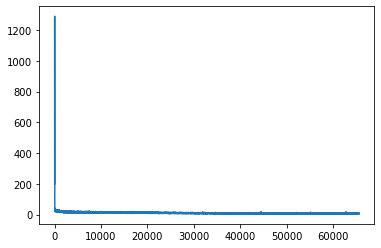

epoch: 36 	 step:0 	 loss: 6.409
epoch: 36 	 step:100 	 loss: 7.941
epoch: 36 	 step:200 	 loss: 7.163
epoch: 36 	 step:300 	 loss: 6.279
epoch: 36 	 step:400 	 loss: 8.585
epoch: 36 	 step:500 	 loss: 7.309
epoch: 36 	 step:600 	 loss: 6.998
epoch: 36 	 step:700 	 loss: 5.414
epoch: 36 	 step:800 	 loss: 6.141
epoch: 36 	 step:900 	 loss: 5.69
epoch: 36 	 step:1000 	 loss: 7.144
epoch: 36 	 step:1100 	 loss: 5.877
epoch: 36 	 step:1200 	 loss: 6.669
epoch: 36 	 step:1300 	 loss: 7.751
epoch: 36 	 step:1400 	 loss: 8.252
epoch: 36 	 step:1500 	 loss: 8.748
epoch: 36 	 step:1600 	 loss: 7.783
epoch: 36 	 step:1700 	 loss: 6.689
epoch: 36 	 step:1800 	 loss: 7.931


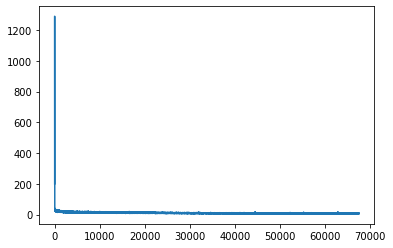

epoch: 37 	 step:0 	 loss: 6.481
epoch: 37 	 step:100 	 loss: 6.603
epoch: 37 	 step:200 	 loss: 7.999
epoch: 37 	 step:300 	 loss: 7.208
epoch: 37 	 step:400 	 loss: 6.493
epoch: 37 	 step:500 	 loss: 7.081
epoch: 37 	 step:600 	 loss: 5.508
epoch: 37 	 step:700 	 loss: 7.309
epoch: 37 	 step:800 	 loss: 7.255
epoch: 37 	 step:900 	 loss: 6.67
epoch: 37 	 step:1000 	 loss: 7.049
epoch: 37 	 step:1100 	 loss: 7.682
epoch: 37 	 step:1200 	 loss: 7.215
epoch: 37 	 step:1300 	 loss: 7.007
epoch: 37 	 step:1400 	 loss: 6.649
epoch: 37 	 step:1500 	 loss: 6.856
epoch: 37 	 step:1600 	 loss: 6.5
epoch: 37 	 step:1700 	 loss: 7.635
epoch: 37 	 step:1800 	 loss: 6.949


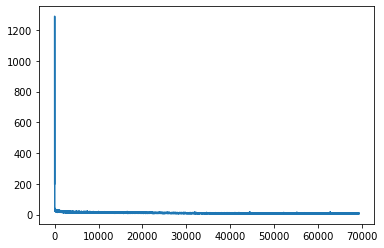

epoch: 38 	 step:0 	 loss: 7.735
epoch: 38 	 step:100 	 loss: 7.714
epoch: 38 	 step:200 	 loss: 7.639
epoch: 38 	 step:300 	 loss: 6.39
epoch: 38 	 step:400 	 loss: 7.101
epoch: 38 	 step:500 	 loss: 6.444
epoch: 38 	 step:600 	 loss: 6.521
epoch: 38 	 step:700 	 loss: 5.623
epoch: 38 	 step:800 	 loss: 7.838
epoch: 38 	 step:900 	 loss: 8.004
epoch: 38 	 step:1000 	 loss: 7.527
epoch: 38 	 step:1100 	 loss: 6.051
epoch: 38 	 step:1200 	 loss: 6.852
epoch: 38 	 step:1300 	 loss: 6.471
epoch: 38 	 step:1400 	 loss: 7.195
epoch: 38 	 step:1500 	 loss: 7.567
epoch: 38 	 step:1600 	 loss: 8.91
epoch: 38 	 step:1700 	 loss: 5.911
epoch: 38 	 step:1800 	 loss: 7.095


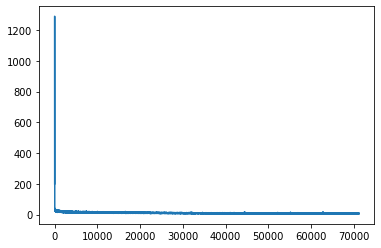

epoch: 39 	 step:0 	 loss: 6.185
epoch: 39 	 step:100 	 loss: 6.037
epoch: 39 	 step:200 	 loss: 5.76
epoch: 39 	 step:300 	 loss: 6.289
epoch: 39 	 step:400 	 loss: 5.916
epoch: 39 	 step:500 	 loss: 7.407
epoch: 39 	 step:600 	 loss: 6.716
epoch: 39 	 step:700 	 loss: 8.117
epoch: 39 	 step:800 	 loss: 7.921
epoch: 39 	 step:900 	 loss: 7.458
epoch: 39 	 step:1000 	 loss: 6.89
epoch: 39 	 step:1100 	 loss: 7.15
epoch: 39 	 step:1200 	 loss: 5.756
epoch: 39 	 step:1300 	 loss: 6.557
epoch: 39 	 step:1400 	 loss: 6.709
epoch: 39 	 step:1500 	 loss: 6.956
epoch: 39 	 step:1600 	 loss: 6.812
epoch: 39 	 step:1700 	 loss: 6.777
epoch: 39 	 step:1800 	 loss: 6.377


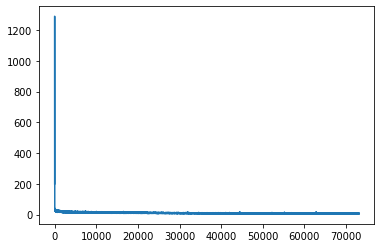

epoch: 40 	 step:0 	 loss: 7.354
epoch: 40 	 step:100 	 loss: 5.4
epoch: 40 	 step:200 	 loss: 8.081
epoch: 40 	 step:300 	 loss: 6.835
epoch: 40 	 step:400 	 loss: 6.133
epoch: 40 	 step:500 	 loss: 6.351
epoch: 40 	 step:600 	 loss: 6.241
epoch: 40 	 step:700 	 loss: 6.5
epoch: 40 	 step:800 	 loss: 6.868
epoch: 40 	 step:900 	 loss: 6.443
epoch: 40 	 step:1000 	 loss: 6.896
epoch: 40 	 step:1100 	 loss: 6.869
epoch: 40 	 step:1200 	 loss: 6.107
epoch: 40 	 step:1300 	 loss: 7.738
epoch: 40 	 step:1400 	 loss: 5.94
epoch: 40 	 step:1500 	 loss: 9.067
epoch: 40 	 step:1600 	 loss: 6.228
epoch: 40 	 step:1700 	 loss: 8.115
epoch: 40 	 step:1800 	 loss: 6.786


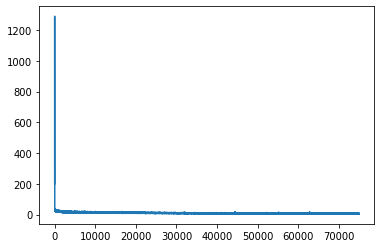

epoch: 41 	 step:0 	 loss: 6.323
epoch: 41 	 step:100 	 loss: 7.895
epoch: 41 	 step:200 	 loss: 6.339
epoch: 41 	 step:300 	 loss: 5.957
epoch: 41 	 step:400 	 loss: 6.136
epoch: 41 	 step:500 	 loss: 6.177
epoch: 41 	 step:600 	 loss: 6.132
epoch: 41 	 step:700 	 loss: 7.693
epoch: 41 	 step:800 	 loss: 7.905
epoch: 41 	 step:900 	 loss: 7.359
epoch: 41 	 step:1000 	 loss: 6.48
epoch: 41 	 step:1100 	 loss: 7.229
epoch: 41 	 step:1200 	 loss: 6.724
epoch: 41 	 step:1300 	 loss: 7.104
epoch: 41 	 step:1400 	 loss: 7.153
epoch: 41 	 step:1500 	 loss: 5.094
epoch: 41 	 step:1600 	 loss: 6.842
epoch: 41 	 step:1700 	 loss: 5.512
epoch: 41 	 step:1800 	 loss: 6.176


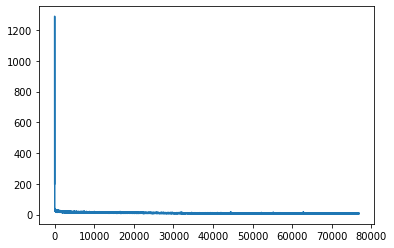

epoch: 42 	 step:0 	 loss: 6.814
epoch: 42 	 step:100 	 loss: 7.38
epoch: 42 	 step:200 	 loss: 8.505
epoch: 42 	 step:300 	 loss: 5.695
epoch: 42 	 step:400 	 loss: 7.4
epoch: 42 	 step:500 	 loss: 7.044
epoch: 42 	 step:600 	 loss: 7.046
epoch: 42 	 step:700 	 loss: 6.103
epoch: 42 	 step:800 	 loss: 7.469
epoch: 42 	 step:900 	 loss: 6.877
epoch: 42 	 step:1000 	 loss: 5.946
epoch: 42 	 step:1100 	 loss: 6.9
epoch: 42 	 step:1200 	 loss: 6.412
epoch: 42 	 step:1300 	 loss: 5.854
epoch: 42 	 step:1400 	 loss: 5.908
epoch: 42 	 step:1500 	 loss: 7.617
epoch: 42 	 step:1600 	 loss: 7.778
epoch: 42 	 step:1700 	 loss: 6.085
epoch: 42 	 step:1800 	 loss: 5.718


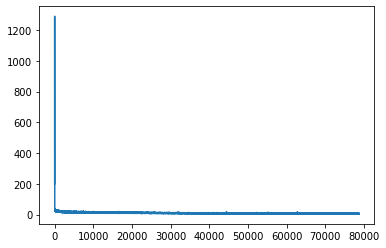

epoch: 43 	 step:0 	 loss: 6.282
epoch: 43 	 step:100 	 loss: 5.723
epoch: 43 	 step:200 	 loss: 6.965
epoch: 43 	 step:300 	 loss: 5.78
epoch: 43 	 step:400 	 loss: 6.055
epoch: 43 	 step:500 	 loss: 6.917
epoch: 43 	 step:600 	 loss: 6.679
epoch: 43 	 step:700 	 loss: 6.098
epoch: 43 	 step:800 	 loss: 6.326
epoch: 43 	 step:900 	 loss: 6.173
epoch: 43 	 step:1000 	 loss: 6.757
epoch: 43 	 step:1100 	 loss: 7.415
epoch: 43 	 step:1200 	 loss: 7.394
epoch: 43 	 step:1300 	 loss: 6.207
epoch: 43 	 step:1400 	 loss: 6.132
epoch: 43 	 step:1500 	 loss: 6.917
epoch: 43 	 step:1600 	 loss: 6.055
epoch: 43 	 step:1700 	 loss: 6.567
epoch: 43 	 step:1800 	 loss: 6.594


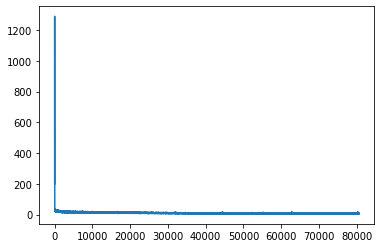

epoch: 44 	 step:0 	 loss: 6.048
epoch: 44 	 step:100 	 loss: 6.967
epoch: 44 	 step:200 	 loss: 5.626
epoch: 44 	 step:300 	 loss: 6.513
epoch: 44 	 step:400 	 loss: 7.578
epoch: 44 	 step:500 	 loss: 7.815
epoch: 44 	 step:600 	 loss: 6.047
epoch: 44 	 step:700 	 loss: 6.201
epoch: 44 	 step:800 	 loss: 5.307
epoch: 44 	 step:900 	 loss: 6.909
epoch: 44 	 step:1000 	 loss: 5.848
epoch: 44 	 step:1100 	 loss: 6.997
epoch: 44 	 step:1200 	 loss: 6.172
epoch: 44 	 step:1300 	 loss: 6.739
epoch: 44 	 step:1400 	 loss: 6.842
epoch: 44 	 step:1500 	 loss: 7.159
epoch: 44 	 step:1600 	 loss: 7.389
epoch: 44 	 step:1700 	 loss: 7.318
epoch: 44 	 step:1800 	 loss: 6.85


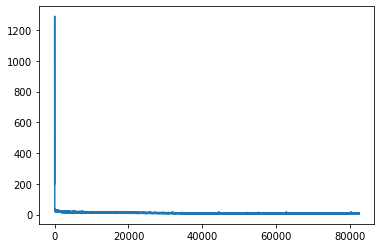

epoch: 45 	 step:0 	 loss: 6.733
epoch: 45 	 step:100 	 loss: 5.65
epoch: 45 	 step:200 	 loss: 6.514
epoch: 45 	 step:300 	 loss: 6.376
epoch: 45 	 step:400 	 loss: 6.58
epoch: 45 	 step:500 	 loss: 6.869
epoch: 45 	 step:600 	 loss: 5.965
epoch: 45 	 step:700 	 loss: 5.555
epoch: 45 	 step:800 	 loss: 6.521
epoch: 45 	 step:900 	 loss: 6.676
epoch: 45 	 step:1000 	 loss: 7.575
epoch: 45 	 step:1100 	 loss: 6.135
epoch: 45 	 step:1200 	 loss: 6.202
epoch: 45 	 step:1300 	 loss: 5.977
epoch: 45 	 step:1400 	 loss: 5.544
epoch: 45 	 step:1500 	 loss: 6.416
epoch: 45 	 step:1600 	 loss: 5.979
epoch: 45 	 step:1700 	 loss: 6.325
epoch: 45 	 step:1800 	 loss: 7.01


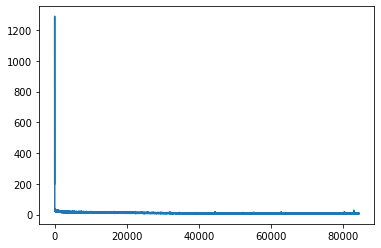

epoch: 46 	 step:0 	 loss: 7.29
epoch: 46 	 step:100 	 loss: 5.8
epoch: 46 	 step:200 	 loss: 6.558
epoch: 46 	 step:300 	 loss: 8.205
epoch: 46 	 step:400 	 loss: 6.274
epoch: 46 	 step:500 	 loss: 7.887
epoch: 46 	 step:600 	 loss: 5.659
epoch: 46 	 step:700 	 loss: 7.135
epoch: 46 	 step:800 	 loss: 6.633
epoch: 46 	 step:900 	 loss: 6.27
epoch: 46 	 step:1000 	 loss: 7.902
epoch: 46 	 step:1100 	 loss: 7.07
epoch: 46 	 step:1200 	 loss: 6.161
epoch: 46 	 step:1300 	 loss: 6.539
epoch: 46 	 step:1400 	 loss: 8.845
epoch: 46 	 step:1500 	 loss: 5.595
epoch: 46 	 step:1600 	 loss: 6.402
epoch: 46 	 step:1700 	 loss: 7.413
epoch: 46 	 step:1800 	 loss: 7.301


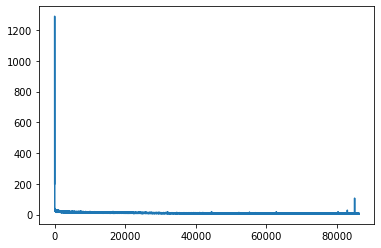

epoch: 47 	 step:0 	 loss: 6.721
epoch: 47 	 step:100 	 loss: 6.33
epoch: 47 	 step:200 	 loss: 5.807
epoch: 47 	 step:300 	 loss: 6.403
epoch: 47 	 step:400 	 loss: 5.904
epoch: 47 	 step:500 	 loss: 5.324
epoch: 47 	 step:600 	 loss: 6.395
epoch: 47 	 step:700 	 loss: 6.961
epoch: 47 	 step:800 	 loss: 6.456
epoch: 47 	 step:900 	 loss: 6.051
epoch: 47 	 step:1000 	 loss: 5.975
epoch: 47 	 step:1100 	 loss: 5.702
epoch: 47 	 step:1200 	 loss: 6.763
epoch: 47 	 step:1300 	 loss: 5.256
epoch: 47 	 step:1400 	 loss: 6.759
epoch: 47 	 step:1500 	 loss: 5.583
epoch: 47 	 step:1600 	 loss: 6.278
epoch: 47 	 step:1700 	 loss: 6.478
epoch: 47 	 step:1800 	 loss: 7.348


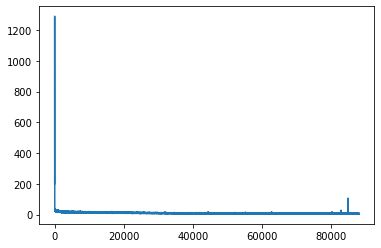

epoch: 48 	 step:0 	 loss: 5.916
epoch: 48 	 step:100 	 loss: 5.63
epoch: 48 	 step:200 	 loss: 5.903
epoch: 48 	 step:300 	 loss: 5.825
epoch: 48 	 step:400 	 loss: 5.88
epoch: 48 	 step:500 	 loss: 6.771
epoch: 48 	 step:600 	 loss: 6.224
epoch: 48 	 step:700 	 loss: 6.073
epoch: 48 	 step:800 	 loss: 6.577
epoch: 48 	 step:900 	 loss: 6.737
epoch: 48 	 step:1000 	 loss: 6.599
epoch: 48 	 step:1100 	 loss: 5.501
epoch: 48 	 step:1200 	 loss: 7.481
epoch: 48 	 step:1300 	 loss: 6.048
epoch: 48 	 step:1400 	 loss: 6.91
epoch: 48 	 step:1500 	 loss: 6.613
epoch: 48 	 step:1600 	 loss: 6.031
epoch: 48 	 step:1700 	 loss: 6.596
epoch: 48 	 step:1800 	 loss: 7.839


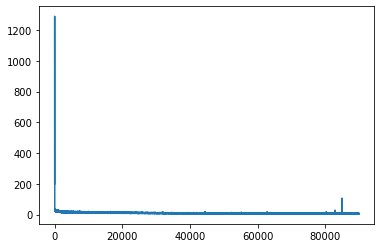

epoch: 49 	 step:0 	 loss: 6.432
epoch: 49 	 step:100 	 loss: 6.787
epoch: 49 	 step:200 	 loss: 7.145
epoch: 49 	 step:300 	 loss: 5.955
epoch: 49 	 step:400 	 loss: 6.902
epoch: 49 	 step:500 	 loss: 5.672
epoch: 49 	 step:600 	 loss: 7.01
epoch: 49 	 step:700 	 loss: 6.429
epoch: 49 	 step:800 	 loss: 5.628
epoch: 49 	 step:900 	 loss: 7.003
epoch: 49 	 step:1000 	 loss: 6.171
epoch: 49 	 step:1100 	 loss: 7.695
epoch: 49 	 step:1200 	 loss: 5.605
epoch: 49 	 step:1300 	 loss: 6.868
epoch: 49 	 step:1400 	 loss: 5.765
epoch: 49 	 step:1500 	 loss: 5.504
epoch: 49 	 step:1600 	 loss: 6.495
epoch: 49 	 step:1700 	 loss: 6.222
epoch: 49 	 step:1800 	 loss: 7.253


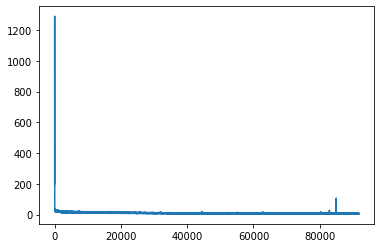

epoch: 50 	 step:0 	 loss: 5.884
epoch: 50 	 step:100 	 loss: 6.544
epoch: 50 	 step:200 	 loss: 6.96
epoch: 50 	 step:300 	 loss: 5.39
epoch: 50 	 step:400 	 loss: 6.404
epoch: 50 	 step:500 	 loss: 6.211
epoch: 50 	 step:600 	 loss: 7.084
epoch: 50 	 step:700 	 loss: 5.657
epoch: 50 	 step:800 	 loss: 6.542
epoch: 50 	 step:900 	 loss: 6.644
epoch: 50 	 step:1000 	 loss: 4.871
epoch: 50 	 step:1100 	 loss: 5.546
epoch: 50 	 step:1200 	 loss: 6.584
epoch: 50 	 step:1300 	 loss: 5.285
epoch: 50 	 step:1400 	 loss: 6.034
epoch: 50 	 step:1500 	 loss: 5.444
epoch: 50 	 step:1600 	 loss: 6.367
epoch: 50 	 step:1700 	 loss: 6.161
epoch: 50 	 step:1800 	 loss: 5.86


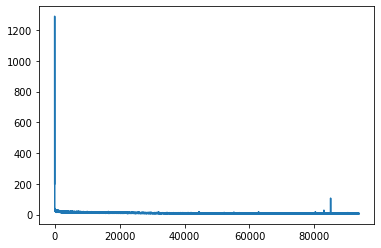

epoch: 51 	 step:0 	 loss: 6.183
epoch: 51 	 step:100 	 loss: 6.857
epoch: 51 	 step:200 	 loss: 5.757
epoch: 51 	 step:300 	 loss: 6.704
epoch: 51 	 step:400 	 loss: 6.674
epoch: 51 	 step:500 	 loss: 6.357
epoch: 51 	 step:600 	 loss: 5.724
epoch: 51 	 step:700 	 loss: 5.595
epoch: 51 	 step:800 	 loss: 5.253
epoch: 51 	 step:900 	 loss: 7.326
epoch: 51 	 step:1000 	 loss: 6.804
epoch: 51 	 step:1100 	 loss: 5.31
epoch: 51 	 step:1200 	 loss: 6.701
epoch: 51 	 step:1300 	 loss: 6.963
epoch: 51 	 step:1400 	 loss: 6.419
epoch: 51 	 step:1500 	 loss: 6.282
epoch: 51 	 step:1600 	 loss: 7.074
epoch: 51 	 step:1700 	 loss: 7.146
epoch: 51 	 step:1800 	 loss: 6.032


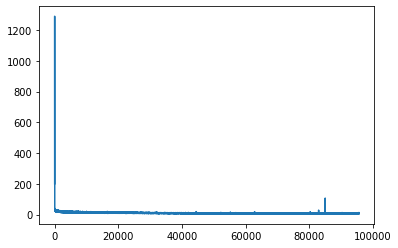

epoch: 52 	 step:0 	 loss: 6.004
epoch: 52 	 step:100 	 loss: 5.685
epoch: 52 	 step:200 	 loss: 6.17
epoch: 52 	 step:300 	 loss: 7.317
epoch: 52 	 step:400 	 loss: 6.229
epoch: 52 	 step:500 	 loss: 6.664
epoch: 52 	 step:600 	 loss: 5.996
epoch: 52 	 step:700 	 loss: 7.564
epoch: 52 	 step:800 	 loss: 5.705
epoch: 52 	 step:900 	 loss: 7.132
epoch: 52 	 step:1000 	 loss: 6.727
epoch: 52 	 step:1100 	 loss: 6.008
epoch: 52 	 step:1200 	 loss: 6.384
epoch: 52 	 step:1300 	 loss: 6.118
epoch: 52 	 step:1400 	 loss: 5.554
epoch: 52 	 step:1500 	 loss: 5.1
epoch: 52 	 step:1600 	 loss: 5.723
epoch: 52 	 step:1700 	 loss: 7.038
epoch: 52 	 step:1800 	 loss: 6.814


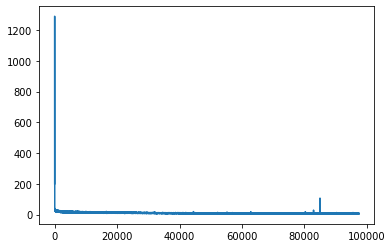

epoch: 53 	 step:0 	 loss: 6.238
epoch: 53 	 step:100 	 loss: 5.428
epoch: 53 	 step:200 	 loss: 6.548
epoch: 53 	 step:300 	 loss: 5.319
epoch: 53 	 step:400 	 loss: 6.566
epoch: 53 	 step:500 	 loss: 5.123
epoch: 53 	 step:600 	 loss: 5.778
epoch: 53 	 step:700 	 loss: 5.145
epoch: 53 	 step:800 	 loss: 8.191
epoch: 53 	 step:900 	 loss: 5.144
epoch: 53 	 step:1000 	 loss: 6.448
epoch: 53 	 step:1100 	 loss: 5.796
epoch: 53 	 step:1200 	 loss: 5.351
epoch: 53 	 step:1300 	 loss: 5.844
epoch: 53 	 step:1400 	 loss: 4.915
epoch: 53 	 step:1500 	 loss: 7.323
epoch: 53 	 step:1600 	 loss: 6.881
epoch: 53 	 step:1700 	 loss: 5.414
epoch: 53 	 step:1800 	 loss: 5.097


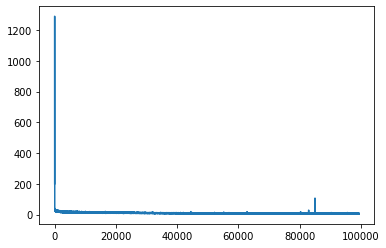

epoch: 54 	 step:0 	 loss: 6.035
epoch: 54 	 step:100 	 loss: 6.035
epoch: 54 	 step:200 	 loss: 6.437
epoch: 54 	 step:300 	 loss: 5.282
epoch: 54 	 step:400 	 loss: 4.631
epoch: 54 	 step:500 	 loss: 5.06
epoch: 54 	 step:600 	 loss: 5.794
epoch: 54 	 step:700 	 loss: 6.547
epoch: 54 	 step:800 	 loss: 5.672
epoch: 54 	 step:900 	 loss: 5.461
epoch: 54 	 step:1000 	 loss: 6.392
epoch: 54 	 step:1100 	 loss: 6.627
epoch: 54 	 step:1200 	 loss: 6.636
epoch: 54 	 step:1300 	 loss: 6.4
epoch: 54 	 step:1400 	 loss: 6.058
epoch: 54 	 step:1500 	 loss: 5.914
epoch: 54 	 step:1600 	 loss: 6.771
epoch: 54 	 step:1700 	 loss: 5.921
epoch: 54 	 step:1800 	 loss: 6.362


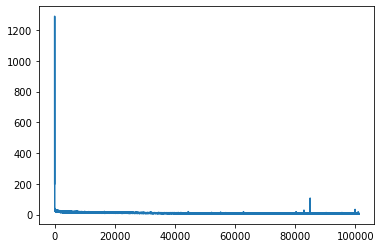

epoch: 55 	 step:0 	 loss: 5.589
epoch: 55 	 step:100 	 loss: 7.138
epoch: 55 	 step:200 	 loss: 6.015
epoch: 55 	 step:300 	 loss: 7.518
epoch: 55 	 step:400 	 loss: 6.893
epoch: 55 	 step:500 	 loss: 5.769
epoch: 55 	 step:600 	 loss: 6.406
epoch: 55 	 step:700 	 loss: 6.051
epoch: 55 	 step:800 	 loss: 5.919
epoch: 55 	 step:900 	 loss: 5.249
epoch: 55 	 step:1000 	 loss: 5.388
epoch: 55 	 step:1100 	 loss: 6.045
epoch: 55 	 step:1200 	 loss: 5.788
epoch: 55 	 step:1300 	 loss: 4.648
epoch: 55 	 step:1400 	 loss: 5.749
epoch: 55 	 step:1500 	 loss: 5.887
epoch: 55 	 step:1600 	 loss: 5.864
epoch: 55 	 step:1700 	 loss: 6.388
epoch: 55 	 step:1800 	 loss: 5.5


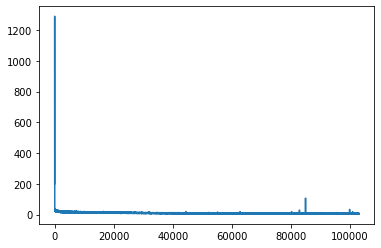

epoch: 56 	 step:0 	 loss: 6.403
epoch: 56 	 step:100 	 loss: 7.178
epoch: 56 	 step:200 	 loss: 5.82
epoch: 56 	 step:300 	 loss: 5.667
epoch: 56 	 step:400 	 loss: 5.553
epoch: 56 	 step:500 	 loss: 6.323
epoch: 56 	 step:600 	 loss: 6.72
epoch: 56 	 step:700 	 loss: 5.487
epoch: 56 	 step:800 	 loss: 6.021
epoch: 56 	 step:900 	 loss: 6.184
epoch: 56 	 step:1000 	 loss: 6.157
epoch: 56 	 step:1100 	 loss: 5.845
epoch: 56 	 step:1200 	 loss: 5.995
epoch: 56 	 step:1300 	 loss: 5.584
epoch: 56 	 step:1400 	 loss: 5.274
epoch: 56 	 step:1500 	 loss: 5.134
epoch: 56 	 step:1600 	 loss: 6.455
epoch: 56 	 step:1700 	 loss: 6.885
epoch: 56 	 step:1800 	 loss: 5.818


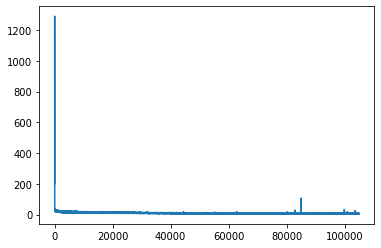

epoch: 57 	 step:0 	 loss: 6.124
epoch: 57 	 step:100 	 loss: 7.634
epoch: 57 	 step:200 	 loss: 5.357
epoch: 57 	 step:300 	 loss: 6.184
epoch: 57 	 step:400 	 loss: 6.188
epoch: 57 	 step:500 	 loss: 6.266
epoch: 57 	 step:600 	 loss: 5.59
epoch: 57 	 step:700 	 loss: 6.801
epoch: 57 	 step:800 	 loss: 5.392
epoch: 57 	 step:900 	 loss: 6.338
epoch: 57 	 step:1000 	 loss: 5.656
epoch: 57 	 step:1100 	 loss: 6.099
epoch: 57 	 step:1200 	 loss: 5.363
epoch: 57 	 step:1300 	 loss: 6.152
epoch: 57 	 step:1400 	 loss: 5.467
epoch: 57 	 step:1500 	 loss: 6.915
epoch: 57 	 step:1600 	 loss: 5.665
epoch: 57 	 step:1700 	 loss: 7.612
epoch: 57 	 step:1800 	 loss: 6.865


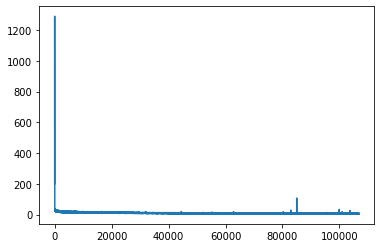

epoch: 58 	 step:0 	 loss: 5.845
epoch: 58 	 step:100 	 loss: 6.345
epoch: 58 	 step:200 	 loss: 5.828
epoch: 58 	 step:300 	 loss: 5.551
epoch: 58 	 step:400 	 loss: 6.025
epoch: 58 	 step:500 	 loss: 6.634
epoch: 58 	 step:600 	 loss: 7.713
epoch: 58 	 step:700 	 loss: 8.7
epoch: 58 	 step:800 	 loss: 6.834
epoch: 58 	 step:900 	 loss: 6.151
epoch: 58 	 step:1000 	 loss: 6.697
epoch: 58 	 step:1100 	 loss: 6.874
epoch: 58 	 step:1200 	 loss: 6.659
epoch: 58 	 step:1300 	 loss: 5.506
epoch: 58 	 step:1400 	 loss: 5.71
epoch: 58 	 step:1500 	 loss: 6.021
epoch: 58 	 step:1600 	 loss: 6.491
epoch: 58 	 step:1700 	 loss: 5.955
epoch: 58 	 step:1800 	 loss: 5.723


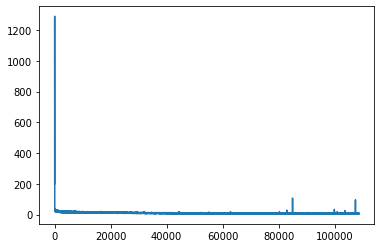

epoch: 59 	 step:0 	 loss: 5.86
epoch: 59 	 step:100 	 loss: 4.972
epoch: 59 	 step:200 	 loss: 6.817
epoch: 59 	 step:300 	 loss: 6.003
epoch: 59 	 step:400 	 loss: 5.989
epoch: 59 	 step:500 	 loss: 4.605
epoch: 59 	 step:600 	 loss: 5.754
epoch: 59 	 step:700 	 loss: 5.764
epoch: 59 	 step:800 	 loss: 6.432
epoch: 59 	 step:900 	 loss: 5.73
epoch: 59 	 step:1000 	 loss: 4.875
epoch: 59 	 step:1100 	 loss: 5.529
epoch: 59 	 step:1200 	 loss: 5.59
epoch: 59 	 step:1300 	 loss: 6.273
epoch: 59 	 step:1400 	 loss: 5.909
epoch: 59 	 step:1500 	 loss: 6.18
epoch: 59 	 step:1600 	 loss: 5.83
epoch: 59 	 step:1700 	 loss: 6.984
epoch: 59 	 step:1800 	 loss: 5.696


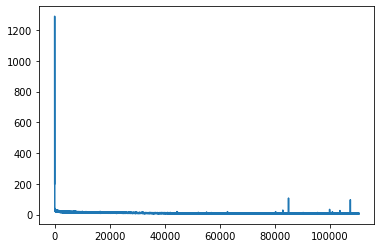

epoch: 60 	 step:0 	 loss: 5.633
epoch: 60 	 step:100 	 loss: 6.769
epoch: 60 	 step:200 	 loss: 6.016
epoch: 60 	 step:300 	 loss: 4.842
epoch: 60 	 step:400 	 loss: 6.375
epoch: 60 	 step:500 	 loss: 5.279
epoch: 60 	 step:600 	 loss: 6.632
epoch: 60 	 step:700 	 loss: 5.865
epoch: 60 	 step:800 	 loss: 6.741
epoch: 60 	 step:900 	 loss: 6.21
epoch: 60 	 step:1000 	 loss: 5.61
epoch: 60 	 step:1100 	 loss: 5.109
epoch: 60 	 step:1200 	 loss: 5.439
epoch: 60 	 step:1300 	 loss: 5.825
epoch: 60 	 step:1400 	 loss: 5.96
epoch: 60 	 step:1500 	 loss: 5.079
epoch: 60 	 step:1600 	 loss: 5.799
epoch: 60 	 step:1700 	 loss: 5.478
epoch: 60 	 step:1800 	 loss: 5.383


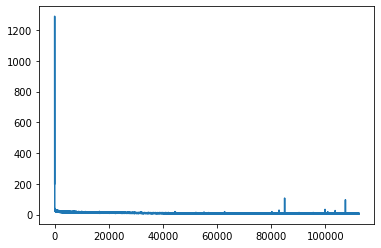

epoch: 61 	 step:0 	 loss: 5.607
epoch: 61 	 step:100 	 loss: 6.046
epoch: 61 	 step:200 	 loss: 6.608
epoch: 61 	 step:300 	 loss: 5.182
epoch: 61 	 step:400 	 loss: 6.43
epoch: 61 	 step:500 	 loss: 6.204
epoch: 61 	 step:600 	 loss: 6.167
epoch: 61 	 step:700 	 loss: 5.844
epoch: 61 	 step:800 	 loss: 5.478
epoch: 61 	 step:900 	 loss: 6.341
epoch: 61 	 step:1000 	 loss: 5.685
epoch: 61 	 step:1100 	 loss: 5.282
epoch: 61 	 step:1200 	 loss: 5.923
epoch: 61 	 step:1300 	 loss: 5.111
epoch: 61 	 step:1400 	 loss: 6.422
epoch: 61 	 step:1500 	 loss: 5.58
epoch: 61 	 step:1600 	 loss: 5.397
epoch: 61 	 step:1700 	 loss: 6.059
epoch: 61 	 step:1800 	 loss: 5.662


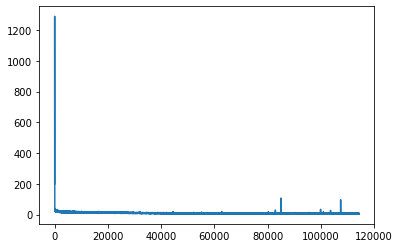

epoch: 62 	 step:0 	 loss: 5.622
epoch: 62 	 step:100 	 loss: 6.228
epoch: 62 	 step:200 	 loss: 4.406
epoch: 62 	 step:300 	 loss: 6.683
epoch: 62 	 step:400 	 loss: 6.827
epoch: 62 	 step:500 	 loss: 5.852
epoch: 62 	 step:600 	 loss: 5.697
epoch: 62 	 step:700 	 loss: 5.716
epoch: 62 	 step:800 	 loss: 6.097
epoch: 62 	 step:900 	 loss: 5.684
epoch: 62 	 step:1000 	 loss: 5.583
epoch: 62 	 step:1100 	 loss: 7.915
epoch: 62 	 step:1200 	 loss: 6.249
epoch: 62 	 step:1300 	 loss: 6.441
epoch: 62 	 step:1400 	 loss: 5.25
epoch: 62 	 step:1500 	 loss: 6.057
epoch: 62 	 step:1600 	 loss: 5.188
epoch: 62 	 step:1700 	 loss: 5.949
epoch: 62 	 step:1800 	 loss: 6.143


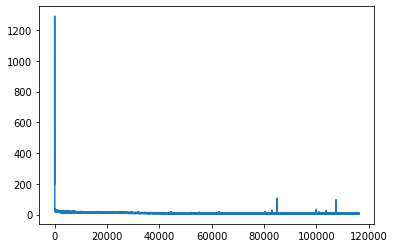

epoch: 63 	 step:0 	 loss: 4.975
epoch: 63 	 step:100 	 loss: 4.943
epoch: 63 	 step:200 	 loss: 4.945
epoch: 63 	 step:300 	 loss: 5.751
epoch: 63 	 step:400 	 loss: 5.762
epoch: 63 	 step:500 	 loss: 6.291
epoch: 63 	 step:600 	 loss: 5.293
epoch: 63 	 step:700 	 loss: 5.916
epoch: 63 	 step:800 	 loss: 6.302
epoch: 63 	 step:900 	 loss: 6.208
epoch: 63 	 step:1000 	 loss: 6.406
epoch: 63 	 step:1100 	 loss: 5.828
epoch: 63 	 step:1200 	 loss: 6.368
epoch: 63 	 step:1300 	 loss: 6.123
epoch: 63 	 step:1400 	 loss: 6.039
epoch: 63 	 step:1500 	 loss: 6.087
epoch: 63 	 step:1600 	 loss: 5.433
epoch: 63 	 step:1700 	 loss: 5.938
epoch: 63 	 step:1800 	 loss: 6.033


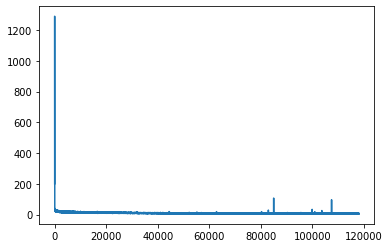

epoch: 64 	 step:0 	 loss: 5.607
epoch: 64 	 step:100 	 loss: 5.624
epoch: 64 	 step:200 	 loss: 6.701
epoch: 64 	 step:300 	 loss: 6.331
epoch: 64 	 step:400 	 loss: 5.18
epoch: 64 	 step:500 	 loss: 5.809
epoch: 64 	 step:600 	 loss: 6.216
epoch: 64 	 step:700 	 loss: 6.615
epoch: 64 	 step:800 	 loss: 4.538
epoch: 64 	 step:900 	 loss: 6.443
epoch: 64 	 step:1000 	 loss: 6.435
epoch: 64 	 step:1100 	 loss: 5.293
epoch: 64 	 step:1200 	 loss: 6.145
epoch: 64 	 step:1300 	 loss: 6.7
epoch: 64 	 step:1400 	 loss: 5.85
epoch: 64 	 step:1500 	 loss: 5.98
epoch: 64 	 step:1600 	 loss: 4.92
epoch: 64 	 step:1700 	 loss: 5.883
epoch: 64 	 step:1800 	 loss: 8.081


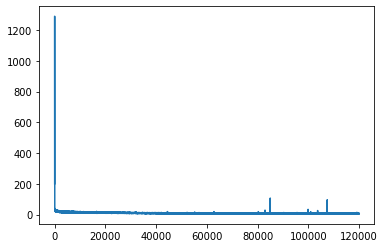

epoch: 65 	 step:0 	 loss: 5.638
epoch: 65 	 step:100 	 loss: 5.493
epoch: 65 	 step:200 	 loss: 6.065
epoch: 65 	 step:300 	 loss: 5.233
epoch: 65 	 step:400 	 loss: 5.575
epoch: 65 	 step:500 	 loss: 4.689
epoch: 65 	 step:600 	 loss: 6.594
epoch: 65 	 step:700 	 loss: 6.542
epoch: 65 	 step:800 	 loss: 5.912
epoch: 65 	 step:900 	 loss: 4.928
epoch: 65 	 step:1000 	 loss: 6.904
epoch: 65 	 step:1100 	 loss: 4.885
epoch: 65 	 step:1200 	 loss: 6.099
epoch: 65 	 step:1300 	 loss: 6.579
epoch: 65 	 step:1400 	 loss: 6.798
epoch: 65 	 step:1500 	 loss: 6.374
epoch: 65 	 step:1600 	 loss: 6.254
epoch: 65 	 step:1700 	 loss: 7.591
epoch: 65 	 step:1800 	 loss: 5.898


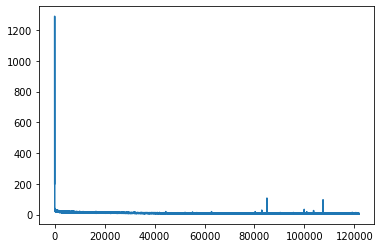

epoch: 66 	 step:0 	 loss: 4.82
epoch: 66 	 step:100 	 loss: 5.302
epoch: 66 	 step:200 	 loss: 5.341
epoch: 66 	 step:300 	 loss: 4.752
epoch: 66 	 step:400 	 loss: 6.829
epoch: 66 	 step:500 	 loss: 4.909
epoch: 66 	 step:600 	 loss: 5.141
epoch: 66 	 step:700 	 loss: 5.494
epoch: 66 	 step:800 	 loss: 5.786
epoch: 66 	 step:900 	 loss: 5.445
epoch: 66 	 step:1000 	 loss: 6.581
epoch: 66 	 step:1100 	 loss: 6.392
epoch: 66 	 step:1200 	 loss: 6.444
epoch: 66 	 step:1300 	 loss: 5.299
epoch: 66 	 step:1400 	 loss: 5.754
epoch: 66 	 step:1500 	 loss: 5.428
epoch: 66 	 step:1600 	 loss: 6.279
epoch: 66 	 step:1700 	 loss: 5.648
epoch: 66 	 step:1800 	 loss: 6.654


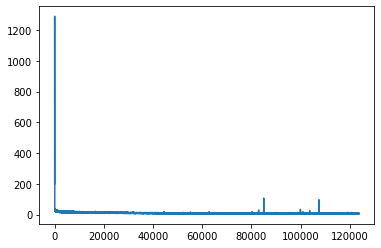

epoch: 67 	 step:0 	 loss: 6.032
epoch: 67 	 step:100 	 loss: 6.366
epoch: 67 	 step:200 	 loss: 6.028
epoch: 67 	 step:300 	 loss: 5.41
epoch: 67 	 step:400 	 loss: 5.264
epoch: 67 	 step:500 	 loss: 5.797
epoch: 67 	 step:600 	 loss: 6.19
epoch: 67 	 step:700 	 loss: 7.203
epoch: 67 	 step:800 	 loss: 5.74
epoch: 67 	 step:900 	 loss: 5.581
epoch: 67 	 step:1000 	 loss: 6.306
epoch: 67 	 step:1100 	 loss: 4.492
epoch: 67 	 step:1200 	 loss: 5.305
epoch: 67 	 step:1300 	 loss: 5.913
epoch: 67 	 step:1400 	 loss: 5.01
epoch: 67 	 step:1500 	 loss: 6.358
epoch: 67 	 step:1600 	 loss: 5.432
epoch: 67 	 step:1700 	 loss: 5.696
epoch: 67 	 step:1800 	 loss: 5.879


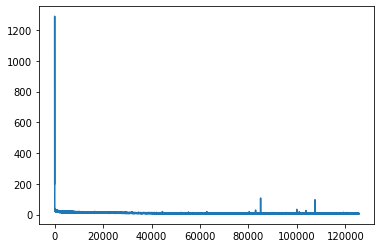

epoch: 68 	 step:0 	 loss: 5.35
epoch: 68 	 step:100 	 loss: 4.17
epoch: 68 	 step:200 	 loss: 6.25
epoch: 68 	 step:300 	 loss: 6.742
epoch: 68 	 step:400 	 loss: 5.516
epoch: 68 	 step:500 	 loss: 5.487
epoch: 68 	 step:600 	 loss: 5.575
epoch: 68 	 step:700 	 loss: 5.643
epoch: 68 	 step:800 	 loss: 5.886
epoch: 68 	 step:900 	 loss: 5.834
epoch: 68 	 step:1000 	 loss: 5.205
epoch: 68 	 step:1100 	 loss: 5.949
epoch: 68 	 step:1200 	 loss: 6.016
epoch: 68 	 step:1300 	 loss: 5.229
epoch: 68 	 step:1400 	 loss: 6.185
epoch: 68 	 step:1500 	 loss: 5.956
epoch: 68 	 step:1600 	 loss: 6.573
epoch: 68 	 step:1700 	 loss: 6.559
epoch: 68 	 step:1800 	 loss: 5.001


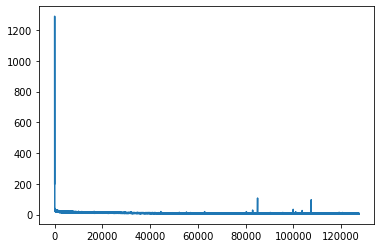

epoch: 69 	 step:0 	 loss: 5.913
epoch: 69 	 step:100 	 loss: 5.213
epoch: 69 	 step:200 	 loss: 5.135
epoch: 69 	 step:300 	 loss: 6.183
epoch: 69 	 step:400 	 loss: 5.208
epoch: 69 	 step:500 	 loss: 4.715
epoch: 69 	 step:600 	 loss: 6.009
epoch: 69 	 step:700 	 loss: 5.827
epoch: 69 	 step:800 	 loss: 5.851
epoch: 69 	 step:900 	 loss: 6.303
epoch: 69 	 step:1000 	 loss: 6.15
epoch: 69 	 step:1100 	 loss: 5.131
epoch: 69 	 step:1200 	 loss: 6.897
epoch: 69 	 step:1300 	 loss: 6.089
epoch: 69 	 step:1400 	 loss: 6.178
epoch: 69 	 step:1500 	 loss: 5.694
epoch: 69 	 step:1600 	 loss: 6.037
epoch: 69 	 step:1700 	 loss: 5.046
epoch: 69 	 step:1800 	 loss: 6.847


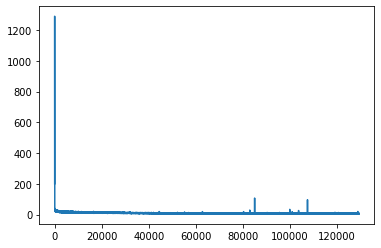

epoch: 70 	 step:0 	 loss: 4.888
epoch: 70 	 step:100 	 loss: 6.046
epoch: 70 	 step:200 	 loss: 5.586
epoch: 70 	 step:300 	 loss: 6.445
epoch: 70 	 step:400 	 loss: 4.815
epoch: 70 	 step:500 	 loss: 6.327
epoch: 70 	 step:600 	 loss: 5.882
epoch: 70 	 step:700 	 loss: 4.715
epoch: 70 	 step:800 	 loss: 5.259
epoch: 70 	 step:900 	 loss: 5.462
epoch: 70 	 step:1000 	 loss: 4.984
epoch: 70 	 step:1100 	 loss: 6.63
epoch: 70 	 step:1200 	 loss: 5.922
epoch: 70 	 step:1300 	 loss: 5.957
epoch: 70 	 step:1400 	 loss: 6.112
epoch: 70 	 step:1500 	 loss: 5.752
epoch: 70 	 step:1600 	 loss: 6.283
epoch: 70 	 step:1700 	 loss: 5.489
epoch: 70 	 step:1800 	 loss: 6.027


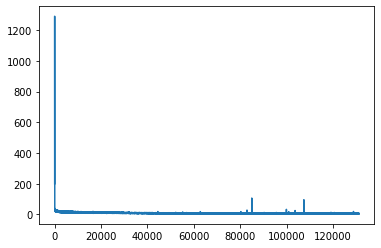

epoch: 71 	 step:0 	 loss: 4.662
epoch: 71 	 step:100 	 loss: 6.039
epoch: 71 	 step:200 	 loss: 5.524
epoch: 71 	 step:300 	 loss: 5.19
epoch: 71 	 step:400 	 loss: 5.893
epoch: 71 	 step:500 	 loss: 5.315
epoch: 71 	 step:600 	 loss: 5.129
epoch: 71 	 step:700 	 loss: 4.707
epoch: 71 	 step:800 	 loss: 5.676
epoch: 71 	 step:900 	 loss: 6.069
epoch: 71 	 step:1000 	 loss: 6.358
epoch: 71 	 step:1100 	 loss: 4.672
epoch: 71 	 step:1200 	 loss: 6.427
epoch: 71 	 step:1300 	 loss: 5.562
epoch: 71 	 step:1400 	 loss: 6.575
epoch: 71 	 step:1500 	 loss: 6.46
epoch: 71 	 step:1600 	 loss: 5.821
epoch: 71 	 step:1700 	 loss: 5.44
epoch: 71 	 step:1800 	 loss: 5.342


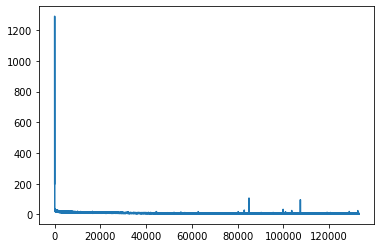

epoch: 72 	 step:0 	 loss: 5.123
epoch: 72 	 step:100 	 loss: 5.306
epoch: 72 	 step:200 	 loss: 5.586
epoch: 72 	 step:300 	 loss: 5.485
epoch: 72 	 step:400 	 loss: 5.469
epoch: 72 	 step:500 	 loss: 5.722
epoch: 72 	 step:600 	 loss: 5.069
epoch: 72 	 step:700 	 loss: 6.452
epoch: 72 	 step:800 	 loss: 5.659
epoch: 72 	 step:900 	 loss: 6.149
epoch: 72 	 step:1000 	 loss: 6.484
epoch: 72 	 step:1100 	 loss: 5.194
epoch: 72 	 step:1200 	 loss: 5.398
epoch: 72 	 step:1300 	 loss: 5.98
epoch: 72 	 step:1400 	 loss: 5.827
epoch: 72 	 step:1500 	 loss: 5.319
epoch: 72 	 step:1600 	 loss: 6.012
epoch: 72 	 step:1700 	 loss: 6.239
epoch: 72 	 step:1800 	 loss: 5.307


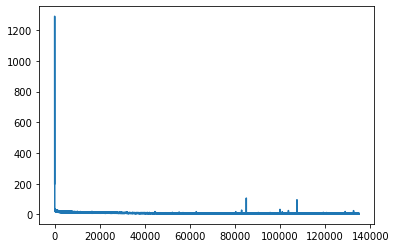

epoch: 73 	 step:0 	 loss: 5.758
epoch: 73 	 step:100 	 loss: 5.556
epoch: 73 	 step:200 	 loss: 7.472
epoch: 73 	 step:300 	 loss: 6.51
epoch: 73 	 step:400 	 loss: 5.806
epoch: 73 	 step:500 	 loss: 5.79
epoch: 73 	 step:600 	 loss: 5.647
epoch: 73 	 step:700 	 loss: 5.133
epoch: 73 	 step:800 	 loss: 5.465
epoch: 73 	 step:900 	 loss: 6.095
epoch: 73 	 step:1000 	 loss: 4.802
epoch: 73 	 step:1100 	 loss: 6.918
epoch: 73 	 step:1200 	 loss: 6.782
epoch: 73 	 step:1300 	 loss: 5.388
epoch: 73 	 step:1400 	 loss: 6.753
epoch: 73 	 step:1500 	 loss: 5.003
epoch: 73 	 step:1600 	 loss: 5.285
epoch: 73 	 step:1700 	 loss: 5.383
epoch: 73 	 step:1800 	 loss: 5.414


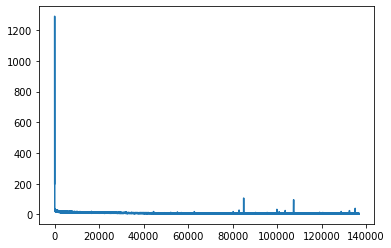

epoch: 74 	 step:0 	 loss: 4.517
epoch: 74 	 step:100 	 loss: 5.778
epoch: 74 	 step:200 	 loss: 5.968
epoch: 74 	 step:300 	 loss: 7.11
epoch: 74 	 step:400 	 loss: 6.026
epoch: 74 	 step:500 	 loss: 5.562
epoch: 74 	 step:600 	 loss: 5.088
epoch: 74 	 step:700 	 loss: 5.338
epoch: 74 	 step:800 	 loss: 4.923
epoch: 74 	 step:900 	 loss: 5.701
epoch: 74 	 step:1000 	 loss: 4.704
epoch: 74 	 step:1100 	 loss: 6.482
epoch: 74 	 step:1200 	 loss: 4.866
epoch: 74 	 step:1300 	 loss: 6.115
epoch: 74 	 step:1400 	 loss: 4.845
epoch: 74 	 step:1500 	 loss: 5.738
epoch: 74 	 step:1600 	 loss: 6.832
epoch: 74 	 step:1700 	 loss: 5.448
epoch: 74 	 step:1800 	 loss: 5.97


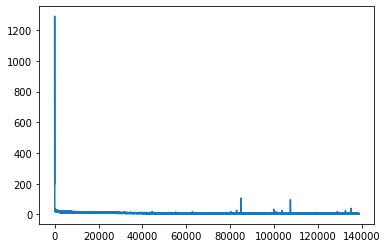

epoch: 75 	 step:0 	 loss: 4.916
epoch: 75 	 step:100 	 loss: 4.923
epoch: 75 	 step:200 	 loss: 5.547
epoch: 75 	 step:300 	 loss: 5.573
epoch: 75 	 step:400 	 loss: 5.089
epoch: 75 	 step:500 	 loss: 6.135
epoch: 75 	 step:600 	 loss: 6.857
epoch: 75 	 step:700 	 loss: 6.591
epoch: 75 	 step:800 	 loss: 5.58
epoch: 75 	 step:900 	 loss: 6.471
epoch: 75 	 step:1000 	 loss: 5.832
epoch: 75 	 step:1100 	 loss: 5.806
epoch: 75 	 step:1200 	 loss: 5.327
epoch: 75 	 step:1300 	 loss: 5.547
epoch: 75 	 step:1400 	 loss: 5.497
epoch: 75 	 step:1500 	 loss: 6.216
epoch: 75 	 step:1600 	 loss: 5.366
epoch: 75 	 step:1700 	 loss: 5.466
epoch: 75 	 step:1800 	 loss: 5.554


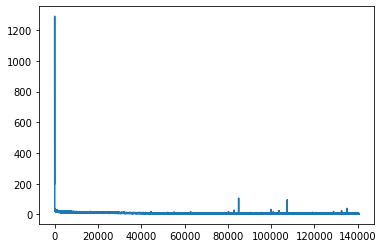

epoch: 76 	 step:0 	 loss: 5.371
epoch: 76 	 step:100 	 loss: 5.588
epoch: 76 	 step:200 	 loss: 4.404
epoch: 76 	 step:300 	 loss: 5.249
epoch: 76 	 step:400 	 loss: 5.718
epoch: 76 	 step:500 	 loss: 5.267
epoch: 76 	 step:600 	 loss: 5.133
epoch: 76 	 step:700 	 loss: 5.033
epoch: 76 	 step:800 	 loss: 6.191
epoch: 76 	 step:900 	 loss: 5.519
epoch: 76 	 step:1000 	 loss: 5.338
epoch: 76 	 step:1100 	 loss: 5.133
epoch: 76 	 step:1200 	 loss: 4.471
epoch: 76 	 step:1300 	 loss: 5.606
epoch: 76 	 step:1400 	 loss: 5.929
epoch: 76 	 step:1500 	 loss: 5.435
epoch: 76 	 step:1600 	 loss: 5.525
epoch: 76 	 step:1700 	 loss: 6.204
epoch: 76 	 step:1800 	 loss: 5.305


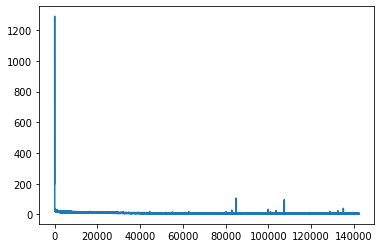

epoch: 77 	 step:0 	 loss: 5.991
epoch: 77 	 step:100 	 loss: 6.654
epoch: 77 	 step:200 	 loss: 5.441
epoch: 77 	 step:300 	 loss: 6.01
epoch: 77 	 step:400 	 loss: 4.337
epoch: 77 	 step:500 	 loss: 5.007
epoch: 77 	 step:600 	 loss: 5.339
epoch: 77 	 step:700 	 loss: 6.356
epoch: 77 	 step:800 	 loss: 4.76
epoch: 77 	 step:900 	 loss: 6.914
epoch: 77 	 step:1000 	 loss: 5.903
epoch: 77 	 step:1100 	 loss: 5.212
epoch: 77 	 step:1200 	 loss: 5.566
epoch: 77 	 step:1300 	 loss: 5.611
epoch: 77 	 step:1400 	 loss: 6.052
epoch: 77 	 step:1500 	 loss: 4.776
epoch: 77 	 step:1600 	 loss: 5.246
epoch: 77 	 step:1700 	 loss: 6.816
epoch: 77 	 step:1800 	 loss: 5.491


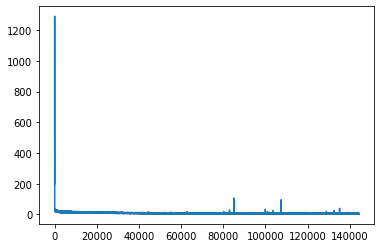

epoch: 78 	 step:0 	 loss: 6.367
epoch: 78 	 step:100 	 loss: 4.889
epoch: 78 	 step:200 	 loss: 5.007
epoch: 78 	 step:300 	 loss: 4.946
epoch: 78 	 step:400 	 loss: 5.545
epoch: 78 	 step:500 	 loss: 5.884
epoch: 78 	 step:600 	 loss: 5.745
epoch: 78 	 step:700 	 loss: 5.75
epoch: 78 	 step:800 	 loss: 5.781
epoch: 78 	 step:900 	 loss: 5.777
epoch: 78 	 step:1000 	 loss: 5.129
epoch: 78 	 step:1100 	 loss: 5.214
epoch: 78 	 step:1200 	 loss: 4.573
epoch: 78 	 step:1300 	 loss: 5.714
epoch: 78 	 step:1400 	 loss: 5.027
epoch: 78 	 step:1500 	 loss: 5.242
epoch: 78 	 step:1600 	 loss: 5.748
epoch: 78 	 step:1700 	 loss: 5.774
epoch: 78 	 step:1800 	 loss: 5.135


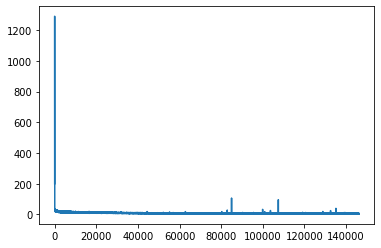

epoch: 79 	 step:0 	 loss: 4.967
epoch: 79 	 step:100 	 loss: 6.015
epoch: 79 	 step:200 	 loss: 5.12
epoch: 79 	 step:300 	 loss: 5.305
epoch: 79 	 step:400 	 loss: 6.412
epoch: 79 	 step:500 	 loss: 5.556
epoch: 79 	 step:600 	 loss: 6.559
epoch: 79 	 step:700 	 loss: 5.778
epoch: 79 	 step:800 	 loss: 6.294
epoch: 79 	 step:900 	 loss: 5.759
epoch: 79 	 step:1000 	 loss: 5.869
epoch: 79 	 step:1100 	 loss: 5.476
epoch: 79 	 step:1200 	 loss: 5.569
epoch: 79 	 step:1300 	 loss: 5.429
epoch: 79 	 step:1400 	 loss: 5.005
epoch: 79 	 step:1500 	 loss: 5.905
epoch: 79 	 step:1600 	 loss: 5.002
epoch: 79 	 step:1700 	 loss: 6.154
epoch: 79 	 step:1800 	 loss: 5.601


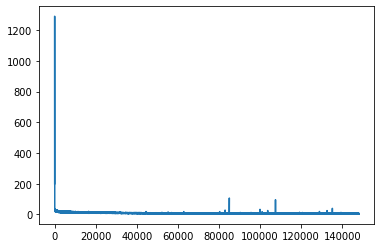

epoch: 80 	 step:0 	 loss: 5.003
epoch: 80 	 step:100 	 loss: 4.945
epoch: 80 	 step:200 	 loss: 5.495
epoch: 80 	 step:300 	 loss: 5.918
epoch: 80 	 step:400 	 loss: 4.941
epoch: 80 	 step:500 	 loss: 5.783
epoch: 80 	 step:600 	 loss: 5.696
epoch: 80 	 step:700 	 loss: 5.293
epoch: 80 	 step:800 	 loss: 6.293
epoch: 80 	 step:900 	 loss: 5.835
epoch: 80 	 step:1000 	 loss: 5.784
epoch: 80 	 step:1100 	 loss: 4.562
epoch: 80 	 step:1200 	 loss: 4.8
epoch: 80 	 step:1300 	 loss: 4.723
epoch: 80 	 step:1400 	 loss: 5.371
epoch: 80 	 step:1500 	 loss: 5.894
epoch: 80 	 step:1600 	 loss: 5.222
epoch: 80 	 step:1700 	 loss: 6.548
epoch: 80 	 step:1800 	 loss: 5.763


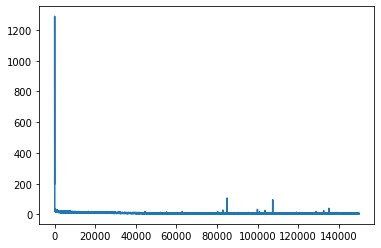

epoch: 81 	 step:0 	 loss: 6.183
epoch: 81 	 step:100 	 loss: 4.92
epoch: 81 	 step:200 	 loss: 5.667
epoch: 81 	 step:300 	 loss: 4.97
epoch: 81 	 step:400 	 loss: 5.828
epoch: 81 	 step:500 	 loss: 5.998
epoch: 81 	 step:600 	 loss: 5.76
epoch: 81 	 step:700 	 loss: 5.487
epoch: 81 	 step:800 	 loss: 4.711
epoch: 81 	 step:900 	 loss: 5.03
epoch: 81 	 step:1000 	 loss: 4.819
epoch: 81 	 step:1100 	 loss: 5.607
epoch: 81 	 step:1200 	 loss: 5.406
epoch: 81 	 step:1300 	 loss: 6.054
epoch: 81 	 step:1400 	 loss: 4.717
epoch: 81 	 step:1500 	 loss: 6.93
epoch: 81 	 step:1600 	 loss: 5.685
epoch: 81 	 step:1700 	 loss: 5.257
epoch: 81 	 step:1800 	 loss: 6.045


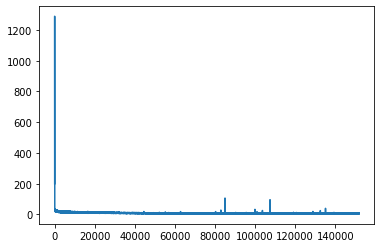

epoch: 82 	 step:0 	 loss: 6.447
epoch: 82 	 step:100 	 loss: 5.127
epoch: 82 	 step:200 	 loss: 4.33
epoch: 82 	 step:300 	 loss: 4.629
epoch: 82 	 step:400 	 loss: 4.659
epoch: 82 	 step:500 	 loss: 6.192
epoch: 82 	 step:600 	 loss: 5.025
epoch: 82 	 step:700 	 loss: 4.576
epoch: 82 	 step:800 	 loss: 6.317
epoch: 82 	 step:900 	 loss: 5.182
epoch: 82 	 step:1000 	 loss: 5.708
epoch: 82 	 step:1100 	 loss: 5.194
epoch: 82 	 step:1200 	 loss: 6.338
epoch: 82 	 step:1300 	 loss: 4.65
epoch: 82 	 step:1400 	 loss: 5.787
epoch: 82 	 step:1500 	 loss: 6.567
epoch: 82 	 step:1600 	 loss: 5.313
epoch: 82 	 step:1700 	 loss: 5.285
epoch: 82 	 step:1800 	 loss: 5.103


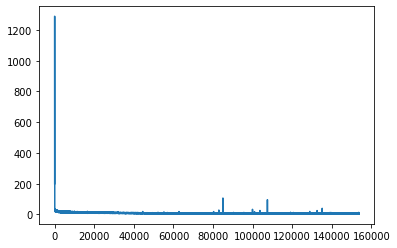

epoch: 83 	 step:0 	 loss: 5.837
epoch: 83 	 step:100 	 loss: 4.873
epoch: 83 	 step:200 	 loss: 4.901
epoch: 83 	 step:300 	 loss: 5.599
epoch: 83 	 step:400 	 loss: 5.039
epoch: 83 	 step:500 	 loss: 5.21
epoch: 83 	 step:600 	 loss: 5.741
epoch: 83 	 step:700 	 loss: 4.701
epoch: 83 	 step:800 	 loss: 5.504
epoch: 83 	 step:900 	 loss: 5.2
epoch: 83 	 step:1000 	 loss: 5.282
epoch: 83 	 step:1100 	 loss: 5.463
epoch: 83 	 step:1200 	 loss: 6.033
epoch: 83 	 step:1300 	 loss: 5.629
epoch: 83 	 step:1400 	 loss: 5.884
epoch: 83 	 step:1500 	 loss: 6.333
epoch: 83 	 step:1600 	 loss: 6.124
epoch: 83 	 step:1700 	 loss: 6.776
epoch: 83 	 step:1800 	 loss: 6.266


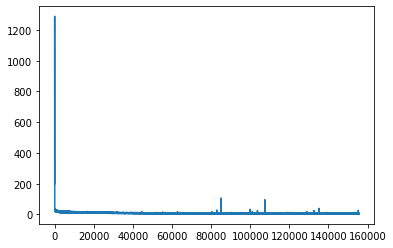

epoch: 84 	 step:0 	 loss: 6.267
epoch: 84 	 step:100 	 loss: 5.886
epoch: 84 	 step:200 	 loss: 4.845
epoch: 84 	 step:300 	 loss: 6.511
epoch: 84 	 step:400 	 loss: 4.963
epoch: 84 	 step:500 	 loss: 4.745
epoch: 84 	 step:600 	 loss: 5.831
epoch: 84 	 step:700 	 loss: 5.056
epoch: 84 	 step:800 	 loss: 5.036
epoch: 84 	 step:900 	 loss: 5.077
epoch: 84 	 step:1000 	 loss: 5.381
epoch: 84 	 step:1100 	 loss: 5.76
epoch: 84 	 step:1200 	 loss: 5.206
epoch: 84 	 step:1300 	 loss: 4.557
epoch: 84 	 step:1400 	 loss: 5.632
epoch: 84 	 step:1500 	 loss: 5.053
epoch: 84 	 step:1600 	 loss: 4.968
epoch: 84 	 step:1700 	 loss: 5.843
epoch: 84 	 step:1800 	 loss: 5.694


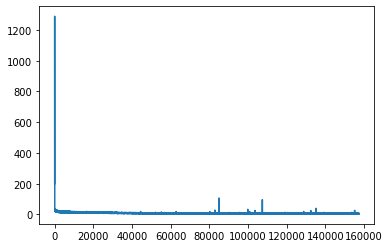

epoch: 85 	 step:0 	 loss: 6.054
epoch: 85 	 step:100 	 loss: 4.905
epoch: 85 	 step:200 	 loss: 4.67
epoch: 85 	 step:300 	 loss: 5.614
epoch: 85 	 step:400 	 loss: 4.715
epoch: 85 	 step:500 	 loss: 4.899
epoch: 85 	 step:600 	 loss: 4.968
epoch: 85 	 step:700 	 loss: 5.315
epoch: 85 	 step:800 	 loss: 5.543
epoch: 85 	 step:900 	 loss: 5.702
epoch: 85 	 step:1000 	 loss: 4.823
epoch: 85 	 step:1100 	 loss: 6.127
epoch: 85 	 step:1200 	 loss: 6.458
epoch: 85 	 step:1300 	 loss: 5.066
epoch: 85 	 step:1400 	 loss: 5.247
epoch: 85 	 step:1500 	 loss: 4.987
epoch: 85 	 step:1600 	 loss: 5.08
epoch: 85 	 step:1700 	 loss: 5.642
epoch: 85 	 step:1800 	 loss: 4.756


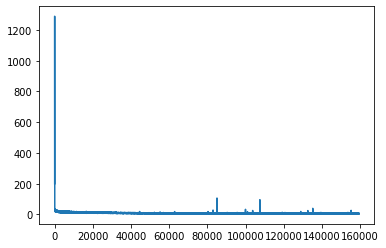

epoch: 86 	 step:0 	 loss: 4.822
epoch: 86 	 step:100 	 loss: 4.459
epoch: 86 	 step:200 	 loss: 5.557
epoch: 86 	 step:300 	 loss: 4.998
epoch: 86 	 step:400 	 loss: 4.929
epoch: 86 	 step:500 	 loss: 5.976
epoch: 86 	 step:600 	 loss: 5.423
epoch: 86 	 step:700 	 loss: 5.497
epoch: 86 	 step:800 	 loss: 5.591
epoch: 86 	 step:900 	 loss: 5.104
epoch: 86 	 step:1000 	 loss: 4.938
epoch: 86 	 step:1100 	 loss: 5.47
epoch: 86 	 step:1200 	 loss: 5.004
epoch: 86 	 step:1300 	 loss: 5.5
epoch: 86 	 step:1400 	 loss: 5.336
epoch: 86 	 step:1500 	 loss: 5.364
epoch: 86 	 step:1600 	 loss: 5.326
epoch: 86 	 step:1700 	 loss: 5.02
epoch: 86 	 step:1800 	 loss: 4.814


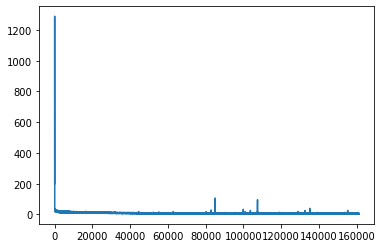

epoch: 87 	 step:0 	 loss: 5.271
epoch: 87 	 step:100 	 loss: 4.742
epoch: 87 	 step:200 	 loss: 4.767
epoch: 87 	 step:300 	 loss: 5.375
epoch: 87 	 step:400 	 loss: 4.919
epoch: 87 	 step:500 	 loss: 6.758
epoch: 87 	 step:600 	 loss: 5.202
epoch: 87 	 step:700 	 loss: 4.513
epoch: 87 	 step:800 	 loss: 4.881
epoch: 87 	 step:900 	 loss: 4.978
epoch: 87 	 step:1000 	 loss: 4.415
epoch: 87 	 step:1100 	 loss: 4.944
epoch: 87 	 step:1200 	 loss: 4.481
epoch: 87 	 step:1300 	 loss: 5.644
epoch: 87 	 step:1400 	 loss: 4.483
epoch: 87 	 step:1500 	 loss: 5.007
epoch: 87 	 step:1600 	 loss: 4.626
epoch: 87 	 step:1700 	 loss: 4.637
epoch: 87 	 step:1800 	 loss: 5.057


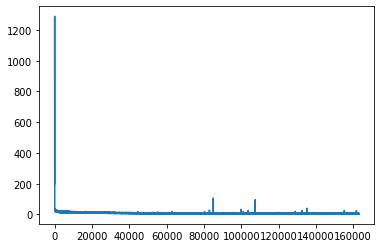

epoch: 88 	 step:0 	 loss: 5.087
epoch: 88 	 step:100 	 loss: 4.99
epoch: 88 	 step:200 	 loss: 5.104
epoch: 88 	 step:300 	 loss: 5.675
epoch: 88 	 step:400 	 loss: 4.993
epoch: 88 	 step:500 	 loss: 6.827
epoch: 88 	 step:600 	 loss: 4.914
epoch: 88 	 step:700 	 loss: 5.136
epoch: 88 	 step:800 	 loss: 5.802
epoch: 88 	 step:900 	 loss: 4.73
epoch: 88 	 step:1000 	 loss: 5.721
epoch: 88 	 step:1100 	 loss: 5.103
epoch: 88 	 step:1200 	 loss: 4.785
epoch: 88 	 step:1300 	 loss: 4.259
epoch: 88 	 step:1400 	 loss: 4.957
epoch: 88 	 step:1500 	 loss: 5.586
epoch: 88 	 step:1600 	 loss: 4.598
epoch: 88 	 step:1700 	 loss: 5.341
epoch: 88 	 step:1800 	 loss: 5.247


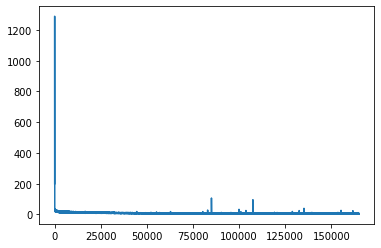

epoch: 89 	 step:0 	 loss: 5.631
epoch: 89 	 step:100 	 loss: 5.301
epoch: 89 	 step:200 	 loss: 4.878
epoch: 89 	 step:300 	 loss: 5.511
epoch: 89 	 step:400 	 loss: 4.794
epoch: 89 	 step:500 	 loss: 5.332
epoch: 89 	 step:600 	 loss: 4.953
epoch: 89 	 step:700 	 loss: 5.04
epoch: 89 	 step:800 	 loss: 5.711
epoch: 89 	 step:900 	 loss: 6.041
epoch: 89 	 step:1000 	 loss: 5.431
epoch: 89 	 step:1100 	 loss: 5.352
epoch: 89 	 step:1200 	 loss: 4.967
epoch: 89 	 step:1300 	 loss: 5.282
epoch: 89 	 step:1400 	 loss: 5.182
epoch: 89 	 step:1500 	 loss: 5.363
epoch: 89 	 step:1600 	 loss: 6.792
epoch: 89 	 step:1700 	 loss: 5.774
epoch: 89 	 step:1800 	 loss: 5.667


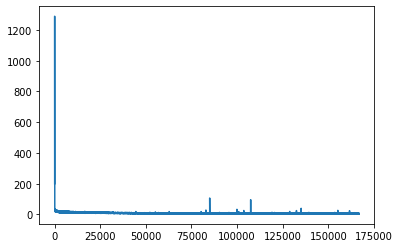

epoch: 90 	 step:0 	 loss: 4.583
epoch: 90 	 step:100 	 loss: 4.502
epoch: 90 	 step:200 	 loss: 5.779
epoch: 90 	 step:300 	 loss: 6.024
epoch: 90 	 step:400 	 loss: 4.79
epoch: 90 	 step:500 	 loss: 5.459
epoch: 90 	 step:600 	 loss: 4.785
epoch: 90 	 step:700 	 loss: 5.804
epoch: 90 	 step:800 	 loss: 5.896
epoch: 90 	 step:900 	 loss: 6.084
epoch: 90 	 step:1000 	 loss: 6.068
epoch: 90 	 step:1100 	 loss: 4.454
epoch: 90 	 step:1200 	 loss: 5.019
epoch: 90 	 step:1300 	 loss: 5.041
epoch: 90 	 step:1400 	 loss: 5.074
epoch: 90 	 step:1500 	 loss: 6.079
epoch: 90 	 step:1600 	 loss: 5.469
epoch: 90 	 step:1700 	 loss: 6.014
epoch: 90 	 step:1800 	 loss: 4.561


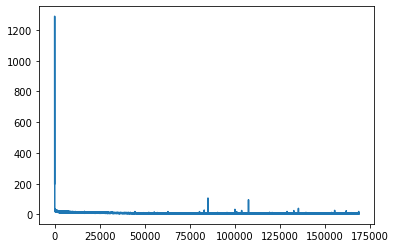

epoch: 91 	 step:0 	 loss: 5.383
epoch: 91 	 step:100 	 loss: 6.031
epoch: 91 	 step:200 	 loss: 4.937
epoch: 91 	 step:300 	 loss: 4.846
epoch: 91 	 step:400 	 loss: 5.396
epoch: 91 	 step:500 	 loss: 4.959
epoch: 91 	 step:600 	 loss: 5.563
epoch: 91 	 step:700 	 loss: 5.234
epoch: 91 	 step:800 	 loss: 5.386
epoch: 91 	 step:900 	 loss: 4.338
epoch: 91 	 step:1000 	 loss: 4.837
epoch: 91 	 step:1100 	 loss: 6.341
epoch: 91 	 step:1200 	 loss: 5.946
epoch: 91 	 step:1300 	 loss: 5.964
epoch: 91 	 step:1400 	 loss: 6.36
epoch: 91 	 step:1500 	 loss: 4.875
epoch: 91 	 step:1600 	 loss: 5.525
epoch: 91 	 step:1700 	 loss: 4.561
epoch: 91 	 step:1800 	 loss: 5.453


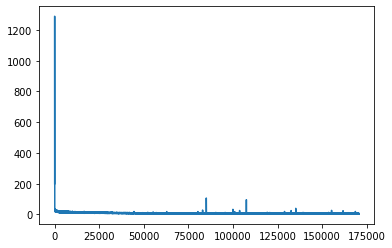

epoch: 92 	 step:0 	 loss: 4.778
epoch: 92 	 step:100 	 loss: 5.529
epoch: 92 	 step:200 	 loss: 4.59
epoch: 92 	 step:300 	 loss: 4.688
epoch: 92 	 step:400 	 loss: 5.181
epoch: 92 	 step:500 	 loss: 5.492
epoch: 92 	 step:600 	 loss: 4.647
epoch: 92 	 step:700 	 loss: 4.844
epoch: 92 	 step:800 	 loss: 4.836
epoch: 92 	 step:900 	 loss: 4.816
epoch: 92 	 step:1000 	 loss: 5.133
epoch: 92 	 step:1100 	 loss: 5.597
epoch: 92 	 step:1200 	 loss: 4.68
epoch: 92 	 step:1300 	 loss: 5.283
epoch: 92 	 step:1400 	 loss: 5.73
epoch: 92 	 step:1500 	 loss: 5.717
epoch: 92 	 step:1600 	 loss: 6.022
epoch: 92 	 step:1700 	 loss: 4.668
epoch: 92 	 step:1800 	 loss: 4.637


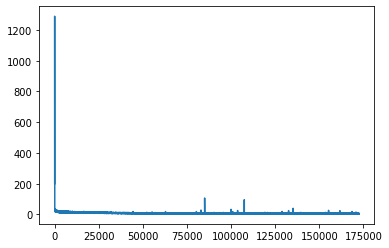

epoch: 93 	 step:0 	 loss: 4.797
epoch: 93 	 step:100 	 loss: 5.677
epoch: 93 	 step:200 	 loss: 5.055
epoch: 93 	 step:300 	 loss: 4.934
epoch: 93 	 step:400 	 loss: 4.823
epoch: 93 	 step:500 	 loss: 4.824
epoch: 93 	 step:600 	 loss: 5.326
epoch: 93 	 step:700 	 loss: 4.94
epoch: 93 	 step:800 	 loss: 5.476
epoch: 93 	 step:900 	 loss: 5.082
epoch: 93 	 step:1000 	 loss: 5.598
epoch: 93 	 step:1100 	 loss: 4.689
epoch: 93 	 step:1200 	 loss: 4.733
epoch: 93 	 step:1300 	 loss: 5.718
epoch: 93 	 step:1400 	 loss: 5.336
epoch: 93 	 step:1500 	 loss: 4.992
epoch: 93 	 step:1600 	 loss: 4.411
epoch: 93 	 step:1700 	 loss: 5.659
epoch: 93 	 step:1800 	 loss: 4.865


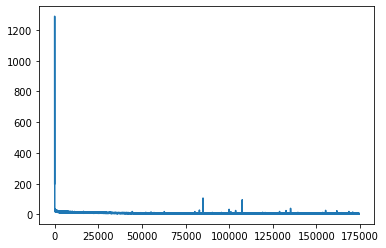

epoch: 94 	 step:0 	 loss: 5.261
epoch: 94 	 step:100 	 loss: 5.303
epoch: 94 	 step:200 	 loss: 5.029
epoch: 94 	 step:300 	 loss: 4.503
epoch: 94 	 step:400 	 loss: 4.959
epoch: 94 	 step:500 	 loss: 5.603
epoch: 94 	 step:600 	 loss: 6.496
epoch: 94 	 step:700 	 loss: 6.266
epoch: 94 	 step:800 	 loss: 4.928
epoch: 94 	 step:900 	 loss: 5.184
epoch: 94 	 step:1000 	 loss: 5.882
epoch: 94 	 step:1100 	 loss: 6.057
epoch: 94 	 step:1200 	 loss: 5.076
epoch: 94 	 step:1300 	 loss: 5.71
epoch: 94 	 step:1400 	 loss: 4.956
epoch: 94 	 step:1500 	 loss: 5.388
epoch: 94 	 step:1600 	 loss: 4.678
epoch: 94 	 step:1700 	 loss: 6.068
epoch: 94 	 step:1800 	 loss: 5.233


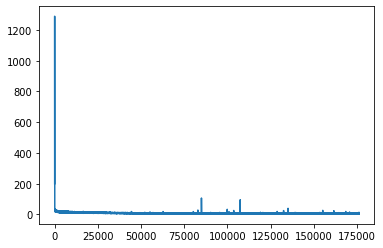

epoch: 95 	 step:0 	 loss: 5.878
epoch: 95 	 step:100 	 loss: 5.987
epoch: 95 	 step:200 	 loss: 5.498
epoch: 95 	 step:300 	 loss: 4.972
epoch: 95 	 step:400 	 loss: 5.076
epoch: 95 	 step:500 	 loss: 4.181
epoch: 95 	 step:600 	 loss: 4.707
epoch: 95 	 step:700 	 loss: 4.506
epoch: 95 	 step:800 	 loss: 4.082
epoch: 95 	 step:900 	 loss: 4.802
epoch: 95 	 step:1000 	 loss: 5.125
epoch: 95 	 step:1100 	 loss: 6.283
epoch: 95 	 step:1200 	 loss: 5.013
epoch: 95 	 step:1300 	 loss: 4.327
epoch: 95 	 step:1400 	 loss: 5.079
epoch: 95 	 step:1500 	 loss: 4.887
epoch: 95 	 step:1600 	 loss: 5.412
epoch: 95 	 step:1700 	 loss: 6.096
epoch: 95 	 step:1800 	 loss: 4.542


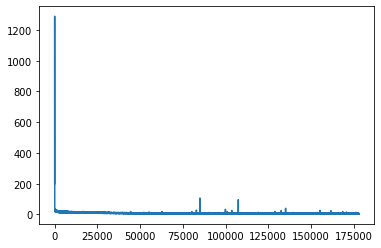

epoch: 96 	 step:0 	 loss: 4.227
epoch: 96 	 step:100 	 loss: 5.164
epoch: 96 	 step:200 	 loss: 4.181
epoch: 96 	 step:300 	 loss: 5.103
epoch: 96 	 step:400 	 loss: 5.646
epoch: 96 	 step:500 	 loss: 5.358
epoch: 96 	 step:600 	 loss: 5.491
epoch: 96 	 step:700 	 loss: 4.453
epoch: 96 	 step:800 	 loss: 4.897
epoch: 96 	 step:900 	 loss: 5.166
epoch: 96 	 step:1000 	 loss: 4.797
epoch: 96 	 step:1100 	 loss: 4.799
epoch: 96 	 step:1200 	 loss: 4.882
epoch: 96 	 step:1300 	 loss: 5.66
epoch: 96 	 step:1400 	 loss: 4.753
epoch: 96 	 step:1500 	 loss: 5.922
epoch: 96 	 step:1600 	 loss: 4.546
epoch: 96 	 step:1700 	 loss: 4.646
epoch: 96 	 step:1800 	 loss: 5.917


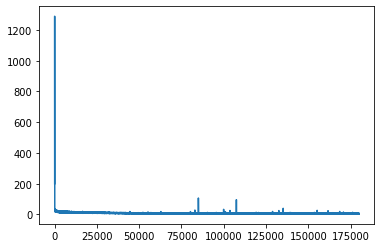

epoch: 97 	 step:0 	 loss: 4.803
epoch: 97 	 step:100 	 loss: 4.441
epoch: 97 	 step:200 	 loss: 5.221
epoch: 97 	 step:300 	 loss: 4.943
epoch: 97 	 step:400 	 loss: 5.387
epoch: 97 	 step:500 	 loss: 5.21
epoch: 97 	 step:600 	 loss: 6.047
epoch: 97 	 step:700 	 loss: 4.769
epoch: 97 	 step:800 	 loss: 4.544
epoch: 97 	 step:900 	 loss: 5.14
epoch: 97 	 step:1000 	 loss: 6.642
epoch: 97 	 step:1100 	 loss: 4.956
epoch: 97 	 step:1200 	 loss: 5.694
epoch: 97 	 step:1300 	 loss: 5.233
epoch: 97 	 step:1400 	 loss: 5.647
epoch: 97 	 step:1500 	 loss: 5.563
epoch: 97 	 step:1600 	 loss: 5.569
epoch: 97 	 step:1700 	 loss: 5.575
epoch: 97 	 step:1800 	 loss: 5.563


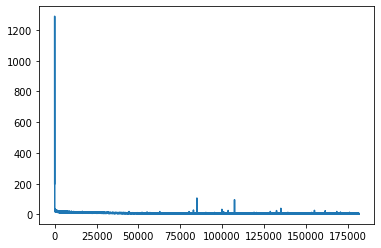

epoch: 98 	 step:0 	 loss: 4.895
epoch: 98 	 step:100 	 loss: 5.139
epoch: 98 	 step:200 	 loss: 4.602
epoch: 98 	 step:300 	 loss: 4.372
epoch: 98 	 step:400 	 loss: 5.697
epoch: 98 	 step:500 	 loss: 4.605
epoch: 98 	 step:600 	 loss: 5.673
epoch: 98 	 step:700 	 loss: 5.402
epoch: 98 	 step:800 	 loss: 5.782
epoch: 98 	 step:900 	 loss: 4.594
epoch: 98 	 step:1000 	 loss: 4.515
epoch: 98 	 step:1100 	 loss: 5.995
epoch: 98 	 step:1200 	 loss: 4.741
epoch: 98 	 step:1300 	 loss: 4.723
epoch: 98 	 step:1400 	 loss: 4.365
epoch: 98 	 step:1500 	 loss: 5.076
epoch: 98 	 step:1600 	 loss: 4.666
epoch: 98 	 step:1700 	 loss: 6.264
epoch: 98 	 step:1800 	 loss: 6.051


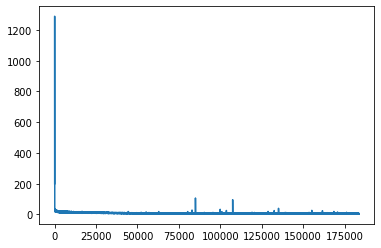

epoch: 99 	 step:0 	 loss: 4.612
epoch: 99 	 step:100 	 loss: 4.227
epoch: 99 	 step:200 	 loss: 4.735
epoch: 99 	 step:300 	 loss: 5.525
epoch: 99 	 step:400 	 loss: 4.5
epoch: 99 	 step:500 	 loss: 5.539
epoch: 99 	 step:600 	 loss: 5.373
epoch: 99 	 step:700 	 loss: 4.691
epoch: 99 	 step:800 	 loss: 6.262
epoch: 99 	 step:900 	 loss: 5.053
epoch: 99 	 step:1000 	 loss: 4.367
epoch: 99 	 step:1100 	 loss: 5.218
epoch: 99 	 step:1200 	 loss: 4.794
epoch: 99 	 step:1300 	 loss: 4.971
epoch: 99 	 step:1400 	 loss: 5.093
epoch: 99 	 step:1500 	 loss: 5.375
epoch: 99 	 step:1600 	 loss: 5.181
epoch: 99 	 step:1700 	 loss: 5.308
epoch: 99 	 step:1800 	 loss: 5.534


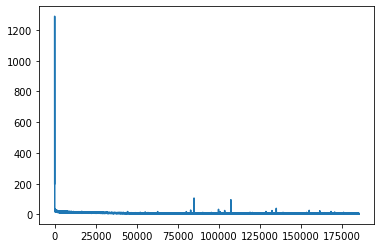

epoch: 100 	 step:0 	 loss: 5.053
epoch: 100 	 step:100 	 loss: 5.289
epoch: 100 	 step:200 	 loss: 5.627
epoch: 100 	 step:300 	 loss: 5.094
epoch: 100 	 step:400 	 loss: 5.26
epoch: 100 	 step:500 	 loss: 5.534
epoch: 100 	 step:600 	 loss: 4.498
epoch: 100 	 step:700 	 loss: 4.547
epoch: 100 	 step:800 	 loss: 5.09
epoch: 100 	 step:900 	 loss: 4.564
epoch: 100 	 step:1000 	 loss: 6.075
epoch: 100 	 step:1100 	 loss: 4.479
epoch: 100 	 step:1200 	 loss: 4.161
epoch: 100 	 step:1300 	 loss: 5.41
epoch: 100 	 step:1400 	 loss: 4.696
epoch: 100 	 step:1500 	 loss: 5.154
epoch: 100 	 step:1600 	 loss: 5.099
epoch: 100 	 step:1700 	 loss: 4.953
epoch: 100 	 step:1800 	 loss: 4.937


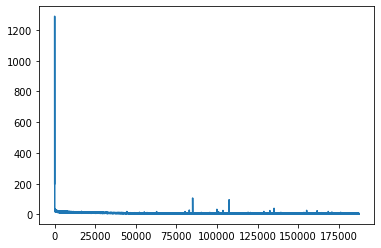

In [16]:
### TRAIN MODEL ###

num_epochs = 100

history = train_model(gen, opt, device, dataloader['train'], epochs=num_epochs)

In [17]:
def test_generator(model, device, testloader, one_batch=False):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        data = data.to(device=device)
        test_images.append(data.cpu().numpy())
        magn, _ = calc_fourier(data)
        out_vec = model(magn)
        out_ft = (magn[..., None]  * out_vec) / (torch.norm(out_vec, dim=-1) + 1e-16)[..., None] 
        out = torch.irfft(out_ft, 2, onesided=False)#, signal_sizes=(data.shape[-2], data.shape[-1]))
        
        outputs.append(out.cpu().detach().numpy())
        if one_batch: break
    
    return np.concatenate(test_images), np.concatenate(outputs)

In [18]:
# Calculate test predictions #

test_original, test_predicted = test_generator(gen, device, dataloader['test'])
print(test_original.shape)
print(test_predicted.shape)

(8000, 1, 28, 28)
(8000, 1, 28, 28)


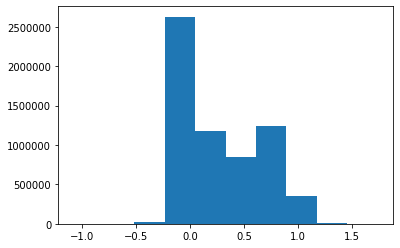

In [19]:
plt.hist(test_predicted.reshape(-1))
plt.show()

Produces negative values!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


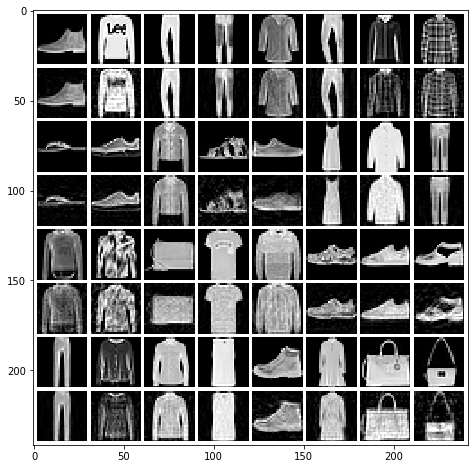

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


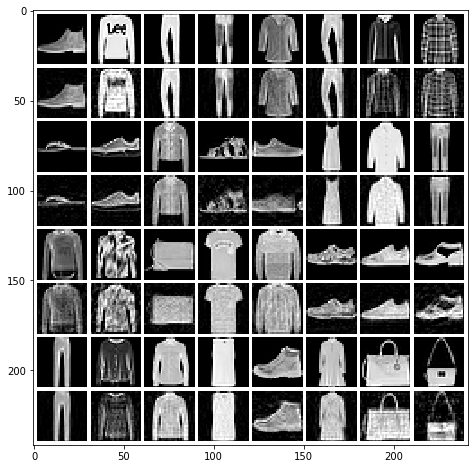

In [20]:
# Print predictions #
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    test_predicted[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8), file="../out/Fashion/end-to-end/phase-prediction/vec-dist.png")

print("Registered:")
results_reg = register_croco(test_predicted[:32], test_original[:32])
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/Fashion/end-to-end/phase-prediction/vec-dist-reg.png")

In [19]:
# Benchmark test predictions #

benchmark(pred=test_predicted[:1024], true=test_original[:1024], check_all=True)

Signal error:
  MSE: 0.018264577928732706, std: 0.01800901542708455
  MAE: 0.0843735901544278, std: 0.04193098149615911
  SSIM: 0.7068417859948852, std: 0.17569573870885954
  Sharpness: 0.15489053306550912, std: 0.06934831208594115
  PhCo-MSE: 0.018898034318738155, std: 0.02894596078304833
  PhCo-MAE: 0.0849049235075654, std: 0.05149670818190502
  PhCo-SSIM: 0.7117916112303733, std: 0.1869381989671665
  CroCo-MSE: 0.015395779305492852, std: 0.01414238966257718
  CroCo-MAE: 0.08021090454712976, std: 0.03795963126913434
  CroCo-SSIM: 0.7283548805106016, std: 0.15430159465144372

Magnitude error:
  MSE Magnitude: 7.910669776368923e-05, std: 0.0011928080005883506

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [-0.71, 1.71] - should be in [0, 1]

Markdown table values:
 0.01826 | 0.08437 | 0.7068 | 0.1549 | 0.01890 | 0.08490 | 0.7118 | 0.01540 | 0.08021 | 0.7284 | 0.00007911 |


## Evaluation for different FC  (1024 samples)


#### Magnitude weight 


| Nr | Loss | Size | epochs| MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | Fourier MSE | 2048 | 100 | 0.01798 | 0.08382 | 0.7092 | 0.1545 | 0.01835 | 0.08420 | 0.7126 | 0.01536 | 0.08004 | 0.7283 | 0.0001801 |

Signal error:
  MSE: 0.01797970967004403, std: 0.01782775223070038
  MAE: 0.08381974746043852, std: 0.041947000104992374
  SSIM: 0.7091681809730852, std: 0.17588301255187863
  Sharpness: 0.15452846949224514, std: 0.0685862262788077
  PhCo-MSE: 0.018347723239685365, std: 0.02436335529889764
  PhCo-MAE: 0.08419907055758813, std: 0.04847105342668412
  PhCo-SSIM: 0.7125558092362927, std: 0.18413856040415197
  CroCo-MSE: 0.015361969494506411, std: 0.014110257899284771
  CroCo-MAE: 0.08004175282439974, std: 0.03811235254092035
  CroCo-SSIM: 0.7283046208297248, std: 0.1562214391714632

Magnitude error:
  MSE Magnitude: 0.00018008202157618764, std: 0.003226116610292413

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [-0.79, 1.67] - should be in [0, 1]